In [7]:
import pickle
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, auc,
                             accuracy_score, mean_squared_error)
import xgboost as xgb
import lightgbm as lgb
import os
import time


train_data= pd.read_csv('/Users/xumoyan/Program/anaconda3/envs/cisc7201/final report/ML/dataset/train_data_encoded.csv')
test_data = pd.read_csv('/Users/xumoyan/Program/anaconda3/envs/cisc7201/final report/ML/dataset/test_data_encoded.csv')
X_train = train_data.drop(columns=['loan_status_flag'])
y_train = train_data['loan_status_flag']
X_test = test_data.drop(columns=['loan_status_flag'])
y_test = test_data['loan_status_flag']

# Configuration
plt.rcParams["font.family"] = ["Arial", "sans-serif"]
sns.set(font_scale=1.2)
os.makedirs("results/plots", exist_ok=True)
os.makedirs("results/text", exist_ok=True)

# Define feature subset
feature_subset = ['num_actv_rev_tl', 'percent_bc_gt_75', 'mort_acc', 'fico_range_low', 'acc_open_past_24mths',
                   'max_bal_bc', 'il_util', 'dti', 'mths_since_recent_bc', 'tot_hi_cred_lim',
                    'annual_inc', 'mo_sin_old_rev_tl_op', 'bc_open_to_buy', 'mths_since_rcnt_il', 'inq_last_6mths',
                    'disbursement_method', 'mo_sin_rcnt_tl', 'int_rate', 'mths_since_recent_inq', 'total_bc_limit', 
                    'all_util', 'sub_grade', 'avg_cur_bal', 'installment', 'term', 
                    'revol_util', 'emp_title_cluster_freq', 'mo_sin_old_il_acct', 'num_bc_tl', 'earliest_cr_line_month', 
                    'emp_title_cluster', 'revol_bal', 'emp_length', 'inq_last_12m', 'bc_util', 
                    'earliest_cr_line_year', 'loan_amnt', 'verification_status_Not Verified', 'pub_rec', 'delinq_2yrs', 
                    'funded_amnt', 'home_ownership_RENT', 'verification_status_Source Verified', 'home_ownership_NONE', 'home_ownership_OWN',
                     'home_ownership_OTHER', 'verification_status_Verified', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'pct_tl_nvr_dlq']


# Initialize results storage
all_results = {}
all_reports = {}


In [ ]:
# Feature Selector
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            missing_features = [f for f in self.feature_names if f not in X.columns]
            if missing_features:
                raise ValueError(f"Missing features: {missing_features}")
        return self
    
    def transform(self, X):
        return X[self.feature_names]

# Visualization functions
def plot_confusion_matrix(cm, model_name, class_names):
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    # Remove grid/guideline
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f'results/plots/{model_name}_confusion_matrix.png', dpi=300)
    plt.close()

def plot_roc_curve(y_true, y_score, title):
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f'results/plots/{title}_roc_curve.png', dpi=300)
    plt.close()

# Result saving functions
def save_model_report(model_name, result, report):
    # Save classification report
    with open(f'results/text/{model_name}_classification_report.txt', 'w') as f:
        f.write(f"{model_name} Classification Report:\n")
        f.write("-" * 50 + "\n")
        f.write(report)
    
    # Save model results
    with open(f'results/text/{model_name}_results.txt', 'w') as f:
        f.write(f"{model_name} Results:\n")
        f.write("-" * 50 + "\n")
        f.write(f"Best Parameters: {result['best_params']}\n")
        f.write(f"Training Time: {result['training_time']:.2f} seconds\n")
        f.write(f"Training ROC-AUC: {result['train_roc_auc']:.4f}\n")
        f.write(f"Testing ROC-AUC: {result['test_roc_auc']:.4f}\n")
        f.write(f"Accuracy: {result['accuracy']:.4f}\n")
        f.write(f"RMSE: {result['rmse']:.4f}\n")
        f.write(f"Recall(Default): {result['tpr']:.4f}\n")
        f.write(f"FPR: {result['fpr']:.4f}\n\n")
        
        # Confusion matrix details
        cm = result['confusion_matrix']
        f.write("Confusion Matrix:\n")
        f.write(f"  True Negatives: {cm[0, 0]}\n")
        f.write(f"  False Positives: {cm[0, 1]}\n")
        f.write(f"  False Negatives: {cm[1, 0]}\n")
        f.write(f"  True Positives: {cm[1, 1]}\n")

# Model 1: Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(feature_subset, X_train, X_test, y_train, y_test):
    model_name = "RandomForest"
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define model and parameters
    model = RandomForestClassifier(
        class_weight='balanced', random_state=42, n_jobs=-1
    )
    params = {
        'model__n_estimators': [500],
        'model__max_features': ['sqrt'],
        'model__max_depth': [15]
    }
    
    # Create pipeline
    pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('model', model)
    ])
    
    # Grid search
    gs = GridSearchCV(
        pipeline, 
        param_grid=params,
        scoring='roc_auc',
        cv=stratified_cv,
        n_jobs=-1,
        verbose=1
    )
    
    # Train
    start_time = time.time()
    gs.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Evaluate
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    train_roc_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba))
    report = classification_report(y_test, y_pred)
    
    # Store results
    result = {
        'best_params': gs.best_params_,
        'train_roc_auc': train_roc_auc,
        'test_roc_auc': test_roc_auc,
        'accuracy': accuracy,
        'rmse': rmse,
        'tpr': tpr,
        'fpr': fpr,
        'y_pred_proba': y_pred_proba,
        'training_time': training_time,
        'confusion_matrix': cm
    }
    
    # Visualize and save
    plot_confusion_matrix(cm, model_name, ['Non-default', 'Default'])
    plot_roc_curve(y_test, y_pred_proba, model_name)
    save_model_report(model_name, result, report)
    
    # Print summary
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {gs.best_params_}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Recall for Default Class (TPR): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    
    return result, report

# Run training
rf_result, rf_report = train_random_forest(feature_subset, X_train, X_test, y_train, y_test)
all_results['RandomForest'] = rf_result
all_reports['RandomForest'] = rf_report

# Save checkpoint
with open('results/rf_results.pkl', 'wb') as f:
    pickle.dump(rf_result, f)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

RandomForest Results:
Best Parameters: {'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__n_estimators': 500}
Training Time: 3023.28 seconds
Training ROC-AUC: 0.8306
Test ROC-AUC: 0.7325
Accuracy: 0.7169
RMSE: 0.4293
Recall for Default Class (TPR): 0.5911
False Positive Rate (FPR): 0.2646


# Model 2: LR

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def train_linear_regression(feature_subset, X_train, X_test, y_train, y_test):
    model_name = "Linear Regression"
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define model and parameters
    model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
    params = {
        'model__C': [100],
        'model__tol': [1e-3, 1e-4, 1e-5]
    }
    
    # Create pipeline
    pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('scaler', StandardScaler()),  
        ('model', model)
    ])
    
    # Grid search
    gs = GridSearchCV(
        pipeline, 
        param_grid=params,
        scoring='roc_auc',
        cv=stratified_cv,
        n_jobs=-1,
        verbose=1
    )
    
    
    # Train
    start_time = time.time()
    gs.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Evaluate
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    train_roc_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba))
    report = classification_report(y_test, y_pred)
    
    # Store results
    result = {
        'best_params': gs.best_params_,
        'train_roc_auc': train_roc_auc,
        'test_roc_auc': test_roc_auc,
        'accuracy': accuracy,
        'rmse': rmse,
        'tpr': tpr,
        'fpr': fpr,
        'y_pred_proba': y_pred_proba,
        'training_time': training_time,
        'confusion_matrix': cm
    }
    
    # Visualize and save
    plot_confusion_matrix(cm, model_name, ['Non-default', 'Default'])
    plot_roc_curve(y_test, y_pred_proba, model_name)
    save_model_report(model_name, result, report)
    
    # Print summary
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {gs.best_params_}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Recall for Default Class (TPR): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    
    return result, report

# Run training
linear_regression_result, linear_regression_report = train_linear_regression(feature_subset, X_train, X_test, y_train, y_test)
all_results['Linear Regression'] = linear_regression_result
all_reports['Linear Regression'] = linear_regression_report

# Save checkpoint
with open('results/linear_regression_results.pkl', 'wb') as f:
    pickle.dump(linear_regression_result, f)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


python(45336) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45337) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45338) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45339) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45340) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45341) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45342) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45343) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Linear Regression Results:
Best Parameters: {'model__C': 100, 'model__tol': 0.0001}
Training Time: 44.25 seconds
Training ROC-AUC: 0.7295
Test ROC-AUC: 0.7282
Accuracy: 0.6777
RMSE: 0.4567
Recall for Default Class (TPR): 0.6487
False Positive Rate (FPR): 0.3180


# Model 3: XGBoost

In [45]:
import xgboost as xgb


def train_xgboost(feature_subset, X_train, X_test, y_train, y_test):
    model_name = "XGBoost"
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
       
    # Define model and parameters
    model = xgb.XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42, n_jobs=-1,
        eval_metric='auc'
    )
    params = {
        'model__n_estimators': [500],
        'model__max_depth': [6],
        'model__learning_rate': [0.1]
    }
    
    # Create pipeline
    pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('model', model)
    ])
    
    # Grid search
    gs = GridSearchCV(
        pipeline, 
        param_grid=params,
        scoring='roc_auc',
        cv=stratified_cv,
        n_jobs=-1,
        verbose=1
    )
    
    # Train
    start_time = time.time()
    gs.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Evaluate
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    train_roc_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba))
    report = classification_report(y_test, y_pred)
    
    # Store results
    result = {
        'best_params': gs.best_params_,
        'train_roc_auc': train_roc_auc,
        'test_roc_auc': test_roc_auc,
        'accuracy': accuracy,
        'rmse': rmse,
        'tpr': tpr,
        'fpr': fpr,
        'y_pred_proba': y_pred_proba,
        'training_time': training_time,
        'confusion_matrix': cm
    }
    
    # Visualize and save
    plot_confusion_matrix(cm, model_name, ['Non-default', 'Default'])
    plot_roc_curve(y_test, y_pred_proba, model_name)
    save_model_report(model_name, result, report)
    
    # Print summary
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {gs.best_params_}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Recall for Default Class (TPR): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    
    return result, report

# Run training
xgb_result, xgb_report = train_xgboost(feature_subset, X_train, X_test, y_train, y_test)
all_results['XGBoost'] = xgb_result
all_reports['XGBoost'] = xgb_report

# Save checkpoint
with open('results/xgb_results.pkl', 'wb') as f:
    pickle.dump(xgb_result, f)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


python(45367) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45368) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



XGBoost Results:
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 500}
Training Time: 78.71 seconds
Training ROC-AUC: 0.7878
Test ROC-AUC: 0.7571
Accuracy: 0.6856
RMSE: 0.4390
Recall for Default Class (TPR): 0.6902
False Positive Rate (FPR): 0.3150


# Model 4: LightGBM

In [55]:
import lightgbm as lgb

def train_lightgbm(feature_subset, X_train, X_test, y_train, y_test):
    model_name = "LightGBM"
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define model and parameters
    model = lgb.LGBMClassifier(
        class_weight='balanced', random_state=42, n_jobs=-1
    )
    params = {
        'model__n_estimators': [500],
        'model__max_depth': [6],
        'model__learning_rate': [0.1]
    }
    
    # Create pipeline
    pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('model', model)
    ])
    
    # Grid search
    gs = GridSearchCV(
        pipeline, 
        param_grid=params,
        scoring='roc_auc',
        cv=stratified_cv,
        n_jobs=-1,
        verbose=1
    )
    
    # Train
    start_time = time.time()
    gs.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Evaluate
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    train_roc_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba))
    report = classification_report(y_test, y_pred)
    
    # Store results
    result = {
        'best_params': gs.best_params_,
        'train_roc_auc': train_roc_auc,
        'test_roc_auc': test_roc_auc,
        'accuracy': accuracy,
        'rmse': rmse,
        'tpr': tpr,
        'fpr': fpr,
        'y_pred_proba': y_pred_proba,
        'training_time': training_time,
        'confusion_matrix': cm
    }
    
    # Visualize and save
    plot_confusion_matrix(cm, model_name, ['Non-default', 'Default'])
    plot_roc_curve(y_test, y_pred_proba, model_name)
    save_model_report(model_name, result, report)
    
    # Print summary
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {gs.best_params_}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Recall for Default Class (TPR): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    
    return result, report

# Run training
lgb_result, lgb_report = train_lightgbm(feature_subset, X_train, X_test, y_train, y_test)
all_results['LightGBM'] = lgb_result
all_reports['LightGBM'] = lgb_report

# Save checkpoint
with open('results/lgb_results.pkl', 'wb') as f:
    pickle.dump(lgb_result, f)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162452, number of negative: 1103096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162453, number of negative: 1103096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162453, number of negative: 1103096
[LightGBM] [Info] Number of positive: 162453, number of negative: 1103096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5851
[LightGBM] [Info] Number of data points in the train set: 1265548, number of used features: 50
[LightGBM] [Info] [binary:BoostFro

# Model 5: ANN

In [49]:
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, mean_squared_error, classification_report
from scipy.stats import randint, uniform
import time
import pickle

def train_ann(feature_subset, X_train, X_test, y_train, y_test):
    model_name = "ANN"
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 定义模型及参数（无需样本权重，用SMOTE处理不平衡）
    model = MLPClassifier(
        max_iter=300,
        early_stopping=True,
        validation_fraction=0.1,
        learning_rate_init=0.001,
        random_state=42
    )
    params = {
        'model__hidden_layer_sizes': [(50, 50, 50)],
        'model__activation': ['relu'],
        'model__solver': ['adam'],
        'model__max_iter': [500]
    }

    # 创建带SMOTE的管道（ImbPipeline支持采样步骤）
    pipeline = ImbPipeline([
        ('feature_selector', FeatureSelector(feature_subset)),  # 特征选择
        ('scaler', RobustScaler()),  # 标准化
        ('smote', SMOTE(random_state=42)),  # 过采样少数类（解决不平衡）
        ('model', model)  # ANN模型
    ])

    # 网格搜索
    gs = GridSearchCV(
        pipeline,
        param_grid=params,
        scoring='roc_auc',
        cv=stratified_cv,
        n_jobs=-1,
        verbose=1
    )

    # 训练：无需传递样本权重，SMOTE已处理不平衡
    start_time = time.time()
    gs.fit(X_train, y_train)  # 不再需要sample_weight参数
    training_time = time.time() - start_time

    # 评估
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # 计算指标（避免除零错误）
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0.0
    train_roc_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1]) if len(np.unique(y_train)) > 1 else 0.5
    test_roc_auc = roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0.5
    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba))
    report = classification_report(y_test, y_pred, zero_division=1)

    # 存储结果
    result = {
        'best_params': gs.best_params_,
        'train_roc_auc': train_roc_auc,
        'test_roc_auc': test_roc_auc,
        'accuracy': accuracy,
        'rmse': rmse,
        'tpr': tpr,
        'fpr': fpr,
        'y_pred_proba': y_pred_proba,
        'training_time': training_time,
        'confusion_matrix': cm
    }

    # 可视化与保存（假设函数已实现）
    plot_confusion_matrix(cm, model_name, ['Non-default', 'Default'])
    plot_roc_curve(y_test, y_pred_proba, model_name)
    save_model_report(model_name, result, report)

    # 打印结果
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {gs.best_params_}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Recall for Default Class (TPR): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")

    return result, report

# 运行训练
ann_result, ann_report = train_ann(feature_subset, X_train, X_test, y_train, y_test)
all_results['ANN'] = ann_result
all_reports['ANN'] = ann_report

# 保存结果
with open('results/ann_results.pkl', 'wb') as f:
    pickle.dump(ann_result, f)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

ANN Results:
Best Parameters: {'model__activation': 'relu', 'model__hidden_layer_sizes': (50, 50, 50), 'model__max_iter': 500, 'model__solver': 'adam'}
Training Time: 1914.72 seconds
Training ROC-AUC: 0.7307
Test ROC-AUC: 0.7253
Accuracy: 0.8134
RMSE: 0.3622
Recall for Default Class (TPR): 0.2893
False Positive Rate (FPR): 0.1094


In [47]:
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, mean_squared_error, classification_report
from scipy.stats import randint, uniform
import time
import pickle

def train_optimized_ann(feature_subset, X_train, X_test, y_train, y_test):
    model_name = "Optimized_ANN"
    # 采用5折交叉验证，更稳健
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 定义基础模型，增加正则化和早停参数
    model = MLPClassifier(
        early_stopping=True,
        validation_fraction=0.2,  # 增加验证集比例
        n_iter_no_change=15,      # 早停耐心值，连续15轮无改进则停止
        tol=1e-4,                 # 改进阈值
        random_state=42,
        verbose=False
    )

    # 扩展超参数搜索空间，使用随机搜索更高效
    param_dist = {
        'model__hidden_layer_sizes': [
            (64, 32), (128, 64), (128, 64, 32) 
        ],
        'model__activation': ['relu'],
        'model__solver': ['adam', 'sgd'],
        'model__alpha': uniform(5e-4, 5e-3),  # L2正则化系数，范围0.0005到0.005
        'model__learning_rate_init': uniform(7e-4, 6e-4),  # 学习率，范围0.0005到0.0015
        'model__learning_rate': ['constant', 'adaptive'],
        'model__max_iter': randint(500, 700),  # 最大迭代次数
        'model__batch_size': randint(64, 128),  # 批大小
        'smote__k_neighbors': randint(4, 6),    # SMOTE邻居数
        'smote__sampling_strategy': [0.7, 0.8, 0.9, 'auto']  # 采样比例
    }

    # 创建增强版管道
    pipeline = ImbPipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        # 可选：添加多项式特征（根据数据情况决定是否启用）
        # ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', RobustScaler()),  # 替换为RobustScaler，更抗异常值
        ('smote', SMOTETomek(random_state=42)),  # 结合过采样和欠采样
        ('model', model)
    ])

    # 使用随机搜索替代网格搜索，效率更高
    gs = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=30,  # 尝试30组参数组合
        scoring='roc_auc',
        cv=stratified_cv,
        n_jobs=-1,  # 使用所有可用CPU
        verbose=1,
        random_state=42
    )

    # 训练模型
    start_time = time.time()
    gs.fit(X_train, y_train)
    training_time = time.time() - start_time

    # 评估最佳模型
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # 计算评估指标
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0.0
    
    # 处理可能的单类别情况
    train_proba = best_model.predict_proba(X_train)[:, 1] if hasattr(best_model, 'predict_proba') else []
    train_roc_auc = roc_auc_score(y_train, train_proba) if len(np.unique(y_train)) > 1 else 0.5
    test_roc_auc = roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0.5
    
    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba))
    report = classification_report(y_test, y_pred, zero_division=1)

    # 存储结果
    result = {
        'best_params': gs.best_params_,
        'train_roc_auc': train_roc_auc,
        'test_roc_auc': test_roc_auc,
        'accuracy': accuracy,
        'rmse': rmse,
        'tpr': tpr,
        'fpr': fpr,
        'y_pred_proba': y_pred_proba,
        'training_time': training_time,
        'confusion_matrix': cm,
        'best_model': best_model  # 保存最佳模型
    }

    # 可视化与保存报告
    plot_confusion_matrix(cm, model_name, ['Non-default', 'Default'])
    plot_roc_curve(y_test, y_pred_proba, model_name)
    save_model_report(model_name, result, report)

    # 打印结果摘要
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {gs.best_params_}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Recall for Default Class (TPR): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")

    return result, report

# 假设以下变量已定义
# feature_subset, X_train, X_test, y_train, y_test, all_results, all_reports

# 运行优化后的模型训练
print("Starting Optimized ANN Training...")
optimized_ann_result, optimized_ann_report = train_optimized_ann(
    feature_subset, X_train, X_test, y_train, y_test
)

# 保存结果
all_results['Optimized_ANN'] = optimized_ann_result
all_reports['Optimized_ANN'] = optimized_ann_report

with open('results/optimized_ann_results.pkl', 'wb') as f:
    pickle.dump(optimized_ann_result, f)

print("\nOptimized ANN training completed!")


Starting Optimized ANN Training...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


python(45477) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45478) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45479) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45480) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45481) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45482) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45483) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45484) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


ValueError: Invalid parameter 'k_neighbors' for estimator SMOTETomek(random_state=42). Valid parameters are: ['n_jobs', 'random_state', 'sampling_strategy', 'smote', 'tomek'].

# Method 6: Hybrid Model: stacking

Creating Stacking Ensemble Model...

Training Stacking_Ensemble
Training base learners and meta-learner...


python(63414) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63415) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63416) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63417) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63418) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63419) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63420) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(63421) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 203066, number of negative: 1378870
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8918
[LightGBM] [Info] Number of data points in the train set: 1581936, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162453, number of negative: 1103096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162453, number of negative: 1103096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.649072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8932
[LightGBM] [Info] Number of data points in the train set: 1265549, number of used features: 88
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 162453, number of negative: 1103096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of posit

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.2min remaining:  7.8min


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.7min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.1min remaining: 10.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.1min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.6min remaining: 12.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.7min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.0min remaining: 14.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.4min finished



Stacking_Ensemble Results:
Base Learners: lr, xgb, lgb, ann
Meta Learner: LogisticRegression
Training Time: 730.25 seconds
Training ROC-AUC: 0.7779
Test ROC-AUC: 0.7581
Accuracy: 0.6847
RMSE: 0.4425
Recall for Default Class (TPR): 0.6937
False Positive Rate (FPR): 0.3167

Analyzing Base Learner Contributions for Stacking_Ensemble
LR - Accuracy: 0.6794, ROC-AUC: 0.7299
XGB - Accuracy: 0.6830, ROC-AUC: 0.7567
LGB - Accuracy: 0.6801, ROC-AUC: 0.7568
ANN - Accuracy: 0.8719, ROC-AUC: 0.7520


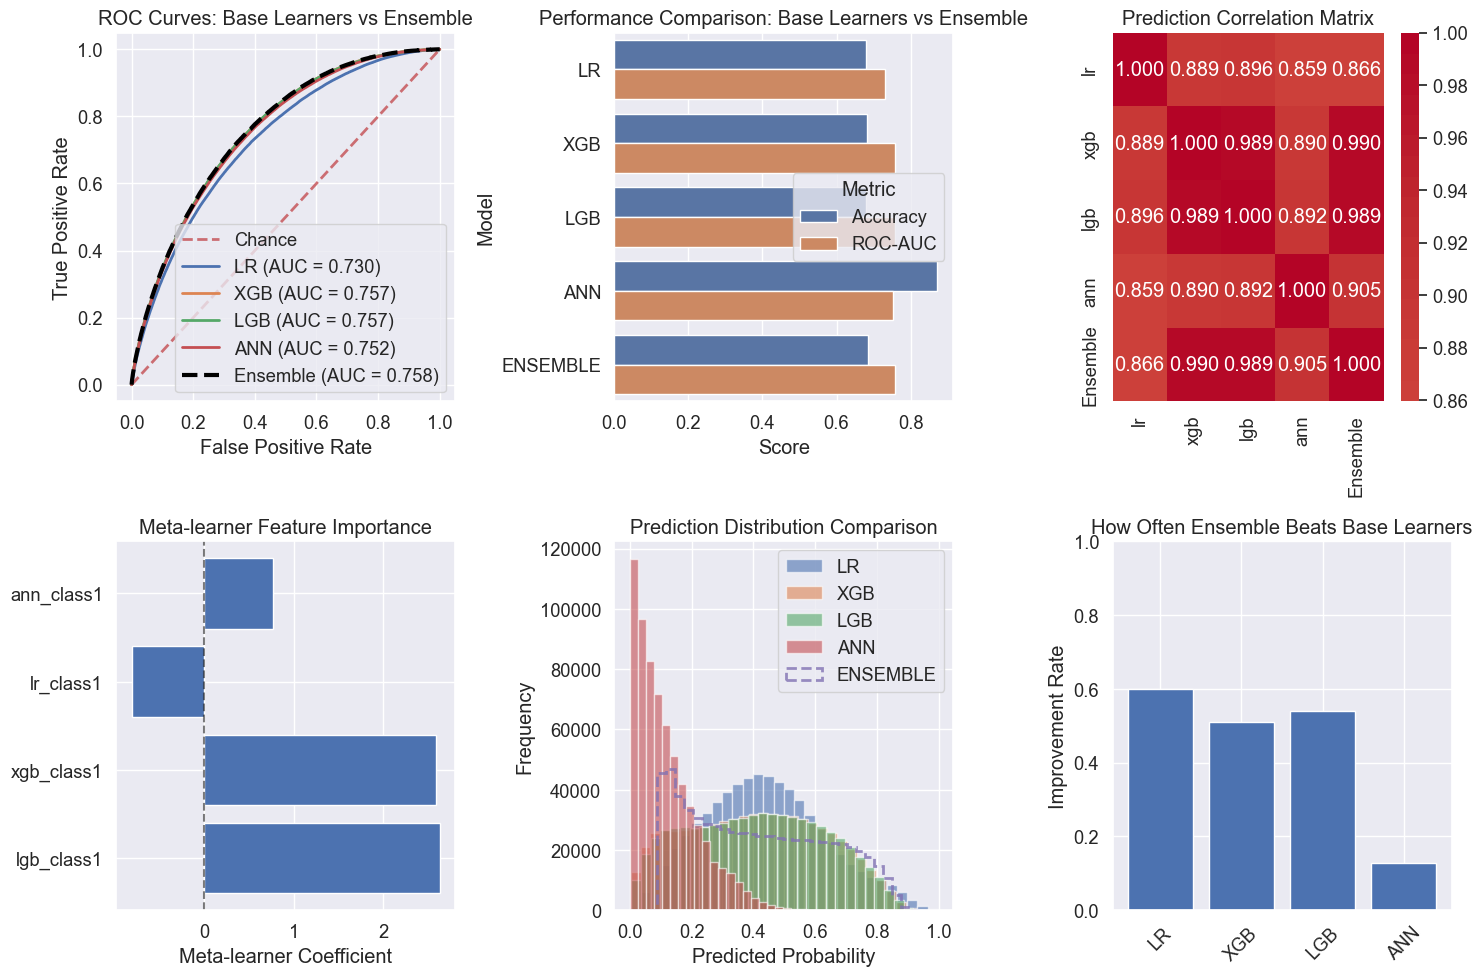

In [63]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, accuracy_score, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

# Assume these helper functions are defined elsewhere in the original code
def FeatureSelector(features):
    """Helper class to select specific features"""
    def __init__(self, features):
        self.features = features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.features]

def plot_confusion_matrix(cm, model_name, classes):
    """Plot and save confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'results/plots/{model_name}_confusion_matrix.png')
    plt.close()

def plot_roc_curve(y_true, y_pred_proba, model_name):
    """Plot and save ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.savefig(f'results/plots/{model_name}_roc_curve.png')
    plt.close()

def save_model_report(model_name, result, report):
    """Save model performance report"""
    report_dir = 'results/reports'
    os.makedirs(report_dir, exist_ok=True)
    report_path = os.path.join(report_dir, f"{model_name}_report.txt")
    with open(report_path, 'w') as f:
        f.write(f"Model: {model_name}\n")
        f.write(f"Training Time: {result['training_time']:.2f} seconds\n")
        f.write(f"Training ROC-AUC: {result['train_roc_auc']:.4f}\n")
        f.write(f"Test ROC-AUC: {result['test_roc_auc']:.4f}\n")
        f.write(f"Accuracy: {result['accuracy']:.4f}\n")
        f.write(f"RMSE: {result['rmse']:.4f}\n")
        f.write(f"Recall (TPR): {result['tpr']:.4f}\n")
        f.write(f"False Positive Rate: {result['fpr']:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report)

def create_stacking_ensemble(feature_subset, X_train, X_test, y_train, y_test):
    """
    Create a stacking ensemble model using multiple base learners
    """
    model_name = "Stacking_Ensemble"
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    
    # Define base learners (level-0 models)
    base_learners = [
        ('lr', Pipeline([
            ('feature_selector', FeatureSelector(feature_subset)),
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(
                class_weight='balanced', 
                random_state=42, 
                max_iter=1000,
                C=100
            ))
        ])),
        ('xgb', Pipeline([
            ('feature_selector', FeatureSelector(feature_subset)),
            ('model', xgb.XGBClassifier(
                n_estimators=300,
                max_depth=6,
                learning_rate=0.1,
                scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
                random_state=42,
                eval_metric='auc',
                n_jobs=-1
            ))
        ])),
        ('lgb', Pipeline([
            ('feature_selector', FeatureSelector(feature_subset)),
            ('model', lgb.LGBMClassifier(
                n_estimators=300,
                max_depth=6,
                learning_rate=0.1,
                class_weight='balanced',
                random_state=42,
                n_jobs=-1
            ))
        ])),
        ('ann', Pipeline([
            ('feature_selector', FeatureSelector(feature_subset)),
            ('scaler', StandardScaler()),
            ('model', MLPClassifier(
                hidden_layer_sizes=(100, 50, 25),
                activation='relu',
                solver='adam',
                max_iter=500,
                learning_rate_init=0.001,
                early_stopping=True,
                validation_fraction=0.1,
                random_state=42
            ))
        ]))
    ]
    
    # Define meta-learner (level-1 model)
    meta_learner = LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    )
    
    # Create stacking classifier
    stacking_clf = StackingClassifier(
        estimators=base_learners,
        final_estimator=meta_learner,
        cv=5,
        stack_method='predict_proba',
        n_jobs=-1,
        verbose=1
    )
    
    # Train the stacking ensemble
    start_time = time.time()
    print("Training base learners and meta-learner...")
    stacking_clf.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Make predictions
    y_pred = stacking_clf.predict(X_test)
    y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    # Training predictions for ROC-AUC
    train_pred_proba = stacking_clf.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, train_pred_proba)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(np.mean((y_test - y_pred_proba) **2))
    report = classification_report(y_test, y_pred)
    
    # Store results
    result = {
        'best_params': 'Stacking Ensemble - No grid search',
        'train_roc_auc': train_roc_auc,
        'test_roc_auc': test_roc_auc,
        'accuracy': accuracy,
        'rmse': rmse,
        'tpr': tpr,
        'fpr': fpr,
        'y_pred_proba': y_pred_proba,
        'training_time': training_time,
        'confusion_matrix': cm,
        'base_learners': [name for name, _ in base_learners],
        'meta_learner': 'LogisticRegression'
    }
    
    # Visualize and save results
    plot_confusion_matrix(cm, model_name, ['Non-default', 'Default'])
    plot_roc_curve(y_test, y_pred_proba, model_name)
    save_model_report(model_name, result, report)
    
    # Print summary
    print(f"\n{model_name} Results:")
    print(f"Base Learners: {', '.join(result['base_learners'])}")
    print(f"Meta Learner: {result['meta_learner']}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Recall for Default Class (TPR): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    
    return stacking_clf, result, report

def analyze_base_learner_contributions(stacking_clf, X_test, y_test, model_name="Stacking_Ensemble"):
    """
    Analyze the contribution of each base learner in the stacking ensemble
    """
    print(f"\n{'='*60}")
    print(f"Analyzing Base Learner Contributions for {model_name}")
    print(f"{'='*60}")
    
    # Get base learner names
    base_learner_names = [name for name, _ in stacking_clf.estimators]
    
    # Get predictions from each base learner
    base_predictions = {}
    base_probabilities = {}
    
    # Use fitted estimators
    for name, estimator in zip(base_learner_names, stacking_clf.estimators_):
        base_pred = estimator.predict(X_test)
        base_pred_proba = estimator.predict_proba(X_test)[:, 1]
    
        base_predictions[name] = base_pred
        base_probabilities[name] = base_pred_proba
    
        base_accuracy = accuracy_score(y_test, base_pred)
        base_roc_auc = roc_auc_score(y_test, base_pred_proba)
        print(f"{name.upper()} - Accuracy: {base_accuracy:.4f}, ROC-AUC: {base_roc_auc:.4f}")
    
    # Visualize base learner performance comparison
    plt.figure(figsize=(15, 10))
    
    # 1. ROC curves for all base learners + ensemble
    plt.subplot(2, 3, 1)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    for name, proba in base_probabilities.items():
        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name.upper()} (AUC = {roc_auc:.3f})')
    
    # Add ensemble ROC
    ensemble_proba = stacking_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, ensemble_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=3, linestyle='--', color='black', 
             label=f'Ensemble (AUC = {roc_auc:.3f})')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves: Base Learners vs Ensemble')
    plt.legend(loc="lower right")
    
    # 2. Performance comparison bar chart
    plt.subplot(2, 3, 2)
    performance_data = []
    for name, proba in base_probabilities.items():
        accuracy = accuracy_score(y_test, base_predictions[name])
        roc_auc = roc_auc_score(y_test, proba)
        performance_data.append({'Model': name.upper(), 'Metric': 'Accuracy', 'Score': accuracy})
        performance_data.append({'Model': name.upper(), 'Metric': 'ROC-AUC', 'Score': roc_auc})
    
    # Add ensemble performance
    ensemble_pred = stacking_clf.predict(X_test)
    ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
    ensemble_roc_auc = roc_auc_score(y_test, ensemble_proba)
    performance_data.append({'Model': 'ENSEMBLE', 'Metric': 'Accuracy', 'Score': ensemble_accuracy})
    performance_data.append({'Model': 'ENSEMBLE', 'Metric': 'ROC-AUC', 'Score': ensemble_roc_auc})
    
    perf_df = pd.DataFrame(performance_data)
    sns.barplot(data=perf_df, x='Score', y='Model', hue='Metric')
    plt.title('Performance Comparison: Base Learners vs Ensemble')
    
    # 3. Prediction correlation matrix
    plt.subplot(2, 3, 3)
    prob_df = pd.DataFrame(base_probabilities)
    prob_df['Ensemble'] = ensemble_proba
    correlation_matrix = prob_df.corr()
    
    sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0)
    plt.title('Prediction Correlation Matrix')
    
    # 4. Meta-learner feature importance (coefficients) - FIXED SECTION
    plt.subplot(2, 3, 4)
    if hasattr(stacking_clf.final_estimator_, 'coef_'):
        meta_coef = stacking_clf.final_estimator_.coef_[0]
        # For binary classification with predict_proba, only 1 feature per base learner is used
        feature_names = [f'{name}_class1' for name in base_learner_names]
        
        # Ensure length match before creating DataFrame
        if len(feature_names) == len(meta_coef):
            coef_df = pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': meta_coef
            }).sort_values('Coefficient', key=abs, ascending=False)
            
            plt.barh(range(len(coef_df)), coef_df['Coefficient'])
            plt.yticks(range(len(coef_df)), coef_df['Feature'])
            plt.xlabel('Meta-learner Coefficient')
            plt.title('Meta-learner Feature Importance')
            plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        else:
            plt.text(0.5, 0.5, f"Mismatch: {len(feature_names)} features vs {len(meta_coef)} coefficients",
                     ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Meta-learner Feature Importance (Mismatch)')
    
    # 5. Prediction distribution comparison
    plt.subplot(2, 3, 5)
    for name, proba in base_probabilities.items():
        plt.hist(proba, alpha=0.6, label=name.upper(), bins=30)
    plt.hist(ensemble_proba, alpha=0.8, label='ENSEMBLE', bins=30, 
             linestyle='--', histtype='step', linewidth=2)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Distribution Comparison')
    plt.legend()
    
    # 6. Ensemble improvement analysis
    plt.subplot(2, 3, 6)
    # Calculate how often ensemble is better than each base learner
    improvement_scores = []
    for name, proba in base_probabilities.items():
        # Compare absolute errors
        base_errors = np.abs(y_test - proba)
        ensemble_errors = np.abs(y_test - ensemble_proba)
        improvement_rate = np.mean(ensemble_errors < base_errors)
        improvement_scores.append({'Base_Learner': name.upper(), 'Improvement_Rate': improvement_rate})
    
    imp_df = pd.DataFrame(improvement_scores)
    plt.bar(imp_df['Base_Learner'], imp_df['Improvement_Rate'])
    plt.ylabel('Improvement Rate')
    plt.title('How Often Ensemble Beats Base Learners')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(f'results/plots/{model_name}_base_learner_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return performance_data, correlation_matrix


print("Creating Stacking Ensemble Model...")
stacking_model, stacking_result, stacking_report = create_stacking_ensemble(
    feature_subset, X_train, X_test, y_train, y_test
)

all_results = {}
all_reports = {}
all_results['Stacking_Ensemble'] = stacking_result
all_reports['Stacking_Ensemble'] = stacking_report

performance_analysis, correlation_analysis = analyze_base_learner_contributions(
    stacking_model, X_test, y_test
)

with open('results/stacking_model.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)

with open('results/stacking_analysis.pkl', 'wb') as f:
    pickle.dump({
        'performance_analysis': performance_analysis,
        'correlation_analysis': correlation_analysis
    }, f)

In [66]:
with open('results/stacking_results.pkl', 'wb') as f:
    pickle.dump(stacking_result, f)

In [ ]:
# Advanced Stacking Techniques and Weighted Ensemble

def create_weighted_ensemble(base_models_results, X_test, y_test, method='performance_weighted'):
    """
    Create a weighted ensemble based on individual model performance
    """
    print(f"\n{'='*60}")
    print(f"Creating Weighted Ensemble - Method: {method}")
    print(f"{'='*60}")
    
    # Exclude stacking from base models for this analysis
    base_models = {k: v for k, v in base_models_results.items() if 'Stacking' not in k}
    
    # Calculate weights based on performance
    if method == 'performance_weighted':
        # Weight based on test ROC-AUC
        weights = []
        total_performance = sum([result['test_roc_auc'] for result in base_models.values()])
        
        for model_name, result in base_models.items():
            weight = result['test_roc_auc'] / total_performance
            weights.append(weight)
            print(f"{model_name}: Weight = {weight:.4f} (ROC-AUC: {result['test_roc_auc']:.4f})")
    
    elif method == 'inverse_error_weighted':
        # Weight based on inverse of RMSE
        weights = []
        rmse_values = [result['rmse'] for result in base_models.values()]
        inverse_rmse = [1/rmse for rmse in rmse_values]
        total_inverse_rmse = sum(inverse_rmse)
        
        for i, (model_name, result) in enumerate(base_models.items()):
            weight = inverse_rmse[i] / total_inverse_rmse
            weights.append(weight)
            print(f"{model_name}: Weight = {weight:.4f} (RMSE: {result['rmse']:.4f})")
    
    elif method == 'equal_weighted':
        # Equal weights
        num_models = len(base_models)
        weights = [1/num_models] * num_models
        print(f"Equal weights: {weights[0]:.4f} for each model")
    
    # Create weighted predictions
    weighted_probas = np.zeros(len(y_test))
    model_names = list(base_models.keys())
    
    for i, (model_name, result) in enumerate(base_models.items()):
        weighted_probas += weights[i] * result['y_pred_proba']
    
    # Generate final predictions
    weighted_pred = (weighted_probas >= 0.5).astype(int)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, weighted_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    test_roc_auc = roc_auc_score(y_test, weighted_probas)
    accuracy = accuracy_score(y_test, weighted_pred)
    rmse = np.sqrt(np.mean((y_test - weighted_probas) ** 2))
    report = classification_report(y_test, weighted_pred)
    
    result = {
        'method': method,
        'weights': dict(zip(model_names, weights)),
        'test_roc_auc': test_roc_auc,
        'accuracy': accuracy,
        'rmse': rmse,
        'tpr': tpr,
        'fpr': fpr,
        'y_pred_proba': weighted_probas,
        'confusion_matrix': cm
    }
    
    print(f"\nWeighted Ensemble Results ({method}):")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Recall for Default Class (TPR): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    
    return result

def create_advanced_stacking_variants(feature_subset, X_train, X_test, y_train, y_test):
    """
    Create different variants of stacking ensembles
    """
    print(f"\n{'='*60}")
    print("Creating Advanced Stacking Variants")
    print(f"{'='*60}")
    
    # Base learners (same as before)
    base_learners = [
        ('rf', Pipeline([
            ('feature_selector', FeatureSelector(feature_subset)),
            ('model', RandomForestClassifier(
                n_estimators=200, max_depth=15, class_weight='balanced', 
                random_state=42, n_jobs=-1
            ))
        ])),
        
        ('lr', Pipeline([
            ('feature_selector', FeatureSelector(feature_subset)),
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(
                class_weight='balanced', random_state=42, max_iter=1000, C=100
            ))
        ])),
        
        ('xgb', Pipeline([
            ('feature_selector', FeatureSelector(feature_subset)),
            ('model', xgb.XGBClassifier(
                n_estimators=200, max_depth=6, learning_rate=0.1,
                scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
                random_state=42, eval_metric='auc', n_jobs=-1
            ))
        ])),
        
        ('lgb', Pipeline([
            ('feature_selector', FeatureSelector(feature_subset)),
            ('model', lgb.LGBMClassifier(
                n_estimators=200, max_depth=6, learning_rate=0.1,
                class_weight='balanced', random_state=42, n_jobs=-1
            ))
        ]))
    ]
    
    stacking_variants = {}
    

    
    # Variant 2: XGBoost as meta-learner
    print("\n2. Stacking with XGBoost Meta-learner")
    meta_xgb = xgb.XGBClassifier(
        n_estimators=100, max_depth=3, learning_rate=0.1,
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42, eval_metric='auc', n_jobs=-1
    )
    
    stacking_xgb = StackingClassifier(
        estimators=base_learners,
        final_estimator=meta_xgb,
        cv=5,
        stack_method='predict_proba',
        n_jobs=-1
    )
    
    start_time = time.time()
    stacking_xgb.fit(X_train, y_train)
    xgb_training_time = time.time() - start_time
    
    xgb_pred = stacking_xgb.predict(X_test)
    xgb_pred_proba = stacking_xgb.predict_proba(X_test)[:, 1]
    xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)
    xgb_accuracy = accuracy_score(y_test, xgb_pred)
    
    stacking_variants['XGB_Meta'] = {
        'model': stacking_xgb,
        'roc_auc': xgb_roc_auc,
        'accuracy': xgb_accuracy,
        'training_time': xgb_training_time,
        'y_pred_proba': xgb_pred_proba
    }
    
    print(f"XGB Meta-learner - ROC-AUC: {xgb_roc_auc:.4f}, Accuracy: {xgb_accuracy:.4f}")
    
    # Variant 3: Multi-level stacking
    print("\n3. Multi-level Stacking")
    # First level: same base learners
    # Second level: combine first level outputs with additional models
    
    # Train first level
    first_level_preds = np.zeros((len(X_train), len(base_learners)))
    first_level_test_preds = np.zeros((len(X_test), len(base_learners)))
    
    # Use cross-validation to get first level predictions
    from sklearn.model_selection import cross_val_predict
    
    for i, (name, estimator) in enumerate(base_learners):
        # Get CV predictions for training data
        cv_preds = cross_val_predict(estimator, X_train, y_train, cv=5, method='predict_proba')
        first_level_preds[:, i] = cv_preds[:, 1]  # Use positive class probabilities
        
        # Fit on full training data and predict test
        estimator.fit(X_train, y_train)
        test_preds = estimator.predict_proba(X_test)
        first_level_test_preds[:, i] = test_preds[:, 1]
    
    # Second level meta-learner
    meta_meta = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
    meta_meta.fit(first_level_preds, y_train)
    
    multilevel_pred_proba = meta_meta.predict_proba(first_level_test_preds)[:, 1]
    multilevel_pred = (multilevel_pred_proba >= 0.5).astype(int)
    multilevel_roc_auc = roc_auc_score(y_test, multilevel_pred_proba)
    multilevel_accuracy = accuracy_score(y_test, multilevel_pred)
    
    stacking_variants['Multi_Level'] = {
        'roc_auc': multilevel_roc_auc,
        'accuracy': multilevel_accuracy,
        'y_pred_proba': multilevel_pred_proba
    }
    
    print(f"Multi-level Stacking - ROC-AUC: {multilevel_roc_auc:.4f}, Accuracy: {multilevel_accuracy:.4f}")
    
    return stacking_variants

def visualize_ensemble_comparison(all_results, weighted_results, stacking_variants):
    """
    Comprehensive visualization comparing all ensemble methods
    """
    print(f"\n{'='*60}")
    print("COMPREHENSIVE ENSEMBLE COMPARISON")
    print(f"{'='*60}")
    
    plt.figure(figsize=(20, 15))
    
    # Prepare data for comparison
    comparison_data = []
    
    # Add base models
    base_models = {k: v for k, v in all_results.items() if 'Stacking' not in k}
    for model_name, result in base_models.items():
        comparison_data.append({
            'Model': model_name,
            'Type': 'Base Model',
            'ROC_AUC': result['test_roc_auc'],
            'Accuracy': result['accuracy'],
            'RMSE': result['rmse']
        })
    
    # Add original stacking
    if 'Stacking_Ensemble' in all_results:
        comparison_data.append({
            'Model': 'Stacking_LR',
            'Type': 'Stacking',
            'ROC_AUC': all_results['Stacking_Ensemble']['test_roc_auc'],
            'Accuracy': all_results['Stacking_Ensemble']['accuracy'],
            'RMSE': all_results['Stacking_Ensemble']['rmse']
        })
    
    # Add weighted ensembles
    for method, result in weighted_results.items():
        comparison_data.append({
            'Model': f'Weighted_{method}',
            'Type': 'Weighted',
            'ROC_AUC': result['test_roc_auc'],
            'Accuracy': result['accuracy'],
            'RMSE': result['rmse']
        })
    
    # Add stacking variants
    for variant_name, result in stacking_variants.items():
        comparison_data.append({
            'Model': f'Stacking_{variant_name}',
            'Type': 'Stacking Variant',
            'ROC_AUC': result['roc_auc'],
            'Accuracy': result['accuracy'],
            'RMSE': result.get('rmse', np.sqrt(np.mean((y_test - result['y_pred_proba']) ** 2)))
        })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # 1. ROC-AUC Comparison
    plt.subplot(3, 3, 1)
    sns.barplot(data=comp_df, x='ROC_AUC', y='Model', hue='Type')
    plt.title('ROC-AUC Comparison Across All Methods')
    plt.xlabel('ROC-AUC Score')
    
    # 2. Accuracy Comparison
    plt.subplot(3, 3, 2)
    sns.barplot(data=comp_df, x='Accuracy', y='Model', hue='Type')
    plt.title('Accuracy Comparison Across All Methods')
    plt.xlabel('Accuracy Score')
    
    # 3. RMSE Comparison
    plt.subplot(3, 3, 3)
    sns.barplot(data=comp_df, x='RMSE', y='Model', hue='Type')
    plt.title('RMSE Comparison Across All Methods')
    plt.xlabel('RMSE Score')
    
    # 4. Performance vs Complexity
    plt.subplot(3, 3, 4)
    complexity_scores = []
    for _, row in comp_df.iterrows():
        if row['Type'] == 'Base Model':
            complexity = 1
        elif row['Type'] == 'Weighted':
            complexity = 2
        elif row['Type'] == 'Stacking':
            complexity = 3
        else:  # Stacking Variant
            complexity = 4
        complexity_scores.append(complexity)
    
    comp_df['Complexity'] = complexity_scores
    plt.scatter(comp_df['Complexity'], comp_df['ROC_AUC'], s=100, alpha=0.7)
    for i, row in comp_df.iterrows():
        plt.annotate(row['Model'], (row['Complexity'], row['ROC_AUC']), 
                    fontsize=8, rotation=45)
    plt.xlabel('Model Complexity')
    plt.ylabel('ROC-AUC')
    plt.title('Performance vs Complexity Trade-off')
    
    # 5. ROC Curves for Top Models
    plt.subplot(3, 3, 5)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    # Plot ROC for top 5 models by ROC-AUC
    top_models = comp_df.nlargest(5, 'ROC_AUC')
    
    for _, row in top_models.iterrows():
        model_name = row['Model']
        
        # Get predictions based on model type
        if model_name in all_results:
            y_pred_proba = all_results[model_name]['y_pred_proba']
        elif 'Weighted_' in model_name:
            method = model_name.replace('Weighted_', '')
            y_pred_proba = weighted_results[method]['y_pred_proba']
        elif 'Stacking_' in model_name and model_name != 'Stacking_LR':
            variant = model_name.replace('Stacking_', '')
            y_pred_proba = stacking_variants[variant]['y_pred_proba']
        else:
            continue
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Top 5 Models')
    plt.legend(loc="lower right", fontsize=8)
    
    # 6. Ensemble Method Performance Distribution
    plt.subplot(3, 3, 6)
    ensemble_df = comp_df[comp_df['Type'].isin(['Weighted', 'Stacking', 'Stacking Variant'])]
    sns.boxplot(data=ensemble_df, x='Type', y='ROC_AUC')
    plt.title('Ensemble Methods Performance Distribution')
    plt.xticks(rotation=45)
    
    # 7. Best Model Summary
    plt.subplot(3, 3, 7)
    plt.axis('off')
    
    best_model = comp_df.loc[comp_df['ROC_AUC'].idxmax()]
    summary_text = f"BEST PERFORMING MODEL:\n\n"
    summary_text += f"Model: {best_model['Model']}\n"
    summary_text += f"Type: {best_model['Type']}\n"
    summary_text += f"ROC-AUC: {best_model['ROC_AUC']:.4f}\n"
    summary_text += f"Accuracy: {best_model['Accuracy']:.4f}\n"
    summary_text += f"RMSE: {best_model['RMSE']:.4f}\n\n"
    
    # Performance improvement
    best_base_model = comp_df[comp_df['Type'] == 'Base Model']['ROC_AUC'].max()
    improvement = ((best_model['ROC_AUC'] - best_base_model) / best_base_model) * 100
    summary_text += f"Improvement over best base model:\n{improvement:.2f}%"
    
    plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    # 8. Ensemble Weight Analysis (for weighted methods)
    plt.subplot(3, 3, 8)
    if weighted_results:
        weight_data = []
        for method, result in weighted_results.items():
            for model, weight in result['weights'].items():
                weight_data.append({
                    'Method': method,
                    'Base_Model': model,
                    'Weight': weight
                })
        
        if weight_data:
            weight_df = pd.DataFrame(weight_data)
            pivot_weights = weight_df.pivot(index='Base_Model', columns='Method', values='Weight')
            sns.heatmap(pivot_weights, annot=True, fmt='.3f', cmap='YlOrRd')
            plt.title('Ensemble Weights Across Methods')
    
    # 9. Model Rankings
    plt.subplot(3, 3, 9)
    comp_df_sorted = comp_df.sort_values('ROC_AUC', ascending=True)
    colors = ['red' if x == 'Base Model' else 'blue' if x == 'Weighted' 
              else 'green' if x == 'Stacking' else 'orange' 
              for x in comp_df_sorted['Type']]
    
    plt.barh(range(len(comp_df_sorted)), comp_df_sorted['ROC_AUC'], color=colors, alpha=0.7)
    plt.yticks(range(len(comp_df_sorted)), comp_df_sorted['Model'])
    plt.xlabel('ROC-AUC Score')
    plt.title('Final Model Rankings')
    
    # Add legend for colors
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.7, label='Base Model'),
        plt.Rectangle((0,0),1,1, facecolor='blue', alpha=0.7, label='Weighted'),
        plt.Rectangle((0,0),1,1, facecolor='green', alpha=0.7, label='Stacking'),
        plt.Rectangle((0,0),1,1, facecolor='orange', alpha=0.7, label='Stacking Variant')
    ]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('results/plots/comprehensive_ensemble_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return comp_df

# Execute the advanced ensemble analysis
print("Starting Advanced Ensemble Analysis...")

# Create weighted ensembles
weighted_ensemble_results = {}
for method in ['performance_weighted', 'inverse_error_weighted', 'equal_weighted']:
    weighted_ensemble_results[method] = create_weighted_ensemble(all_results, X_test, y_test, method)

# Create stacking variants
stacking_variants = create_advanced_stacking_variants(feature_subset, X_train, X_test, y_train, y_test)

# Comprehensive comparison
final_comparison = visualize_ensemble_comparison(all_results, weighted_ensemble_results, stacking_variants)

# Save all ensemble results
ensemble_results = {
    'weighted_ensembles': weighted_ensemble_results,
    'stacking_variants': stacking_variants,
    'final_comparison': final_comparison
}

with open('results/comprehensive_ensemble_analysis.pkl', 'wb') as f:
    pickle.dump(ensemble_results, f)

# Print final summary
print(f"\n{'='*80}")
print("ENSEMBLE ANALYSIS COMPLETE!")
print(f"{'='*80}")

best_model = final_comparison.loc[final_comparison['ROC_AUC'].idxmax()]
print(f"Best Performing Model: {best_model['Model']}")
print(f"ROC-AUC: {best_model['ROC_AUC']:.4f}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"Type: {best_model['Type']}")

print("\nFiles Generated:")
print("- Stacking model: results/stacking_model.pkl")
print("- Stacking analysis: results/stacking_analysis.pkl")  
print("- Comprehensive ensemble analysis: results/comprehensive_ensemble_analysis.pkl")
print("- Visualization: results/plots/comprehensive_ensemble_comparison.png")

# Comparsion Visualization

成功加载模型结果: RandomForest
成功加载模型结果: Linear Regression
成功加载模型结果: XGBoost
成功加载模型结果: LightGBM
成功加载模型结果: ANN
结果已保存至 results/text/model_comparison_summary.txt

Performance Summary of Models:
----------------------------------------------------------------------------------------------------
Model           Train Time(s) Train ROC-AUC Test ROC-AUC Accuracy   RMSE     Recall(Default) FPR
----------------------------------------------------------------------------------------------------
LightGBM        79.62        0.7765       0.7571       0.6825     0.4406   0.6931         0.3190
XGBoost         78.71        0.7878       0.7571       0.6856     0.4390   0.6902         0.3150
RandomForest    3023.28      0.8306       0.7325       0.7169     0.4293   0.5911         0.2646
Linear Regression 44.25        0.7295       0.7282       0.6777     0.4567   0.6487         0.3180
ANN             1914.72      0.7307       0.7253       0.8134     0.3622   0.2893         0.1094
-------------------------------

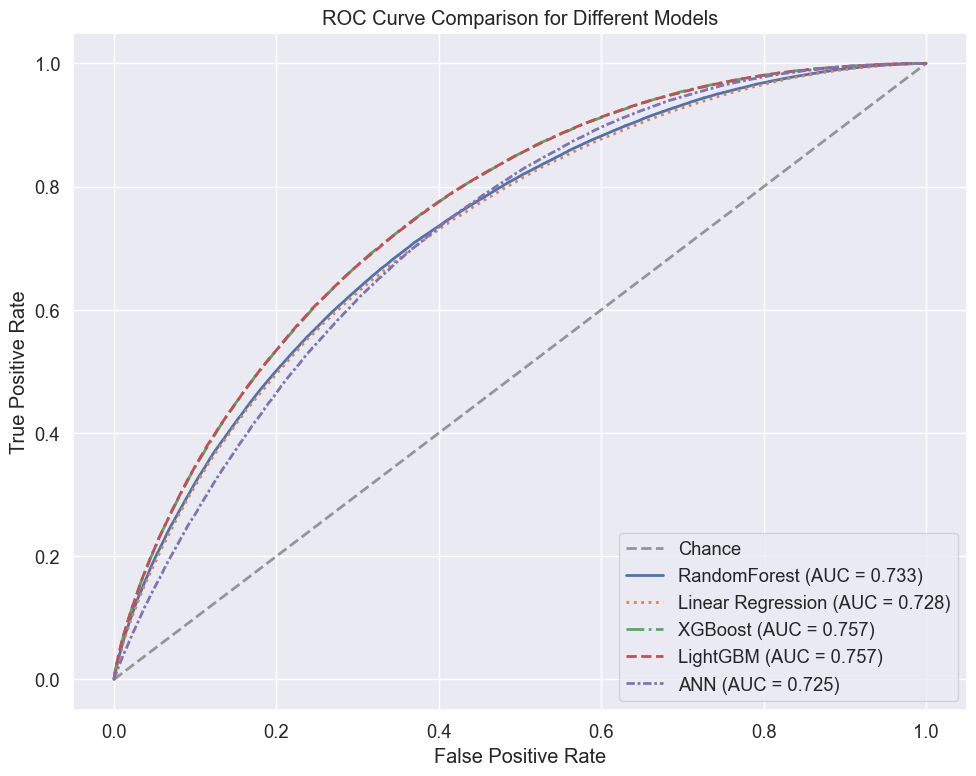

ROC曲线对比图已保存至 results/plots/model_roc_curve_comparison.png


In [67]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import os

# --------------------------
# 1. 从文件加载模型结果（关键修改）
# --------------------------
def load_model_results(result_dir='results'):
    """从保存的pkl文件加载所有模型结果，支持单独运行可视化代码"""
    # 定义模型名称映射：简写 -> 完整大写名称
    model_name_mapping = {
        'rf': 'RandomForest',
        'linear_regression': 'Linear Regression',
        'xgb': 'XGBoost',
        'lgb': 'LightGBM',
        'ann': 'ANN'
    }
    all_results = {}
    
    for model in model_name_mapping.keys():
        pkl_path = os.path.join(result_dir, f'{model}_results.pkl')
        try:
            with open(pkl_path, 'rb') as f:
                # 用完整大写名称作为字典键
                all_results[model_name_mapping[model]] = pickle.load(f)
            print(f"成功加载模型结果: {model_name_mapping[model]}")
        except FileNotFoundError:
            print(f"警告: 未找到 {model} 的结果文件 {pkl_path}，已跳过")
    
    # 读取测试集标签（需确保y_test已保存，若未保存可手动加载）
    try:
        with open(os.path.join(result_dir, 'y_test.pkl'), 'rb') as f:
            y_test = pickle.load(f)
    except FileNotFoundError:
        print("未找到保存的y_test，尝试从原始数据加载...")
        test_data = pd.read_csv('/Users/xumoyan/Program/anaconda3/envs/cisc7201/final report/ML/dataset/test_data_encoded.csv')
        y_test = test_data['loan_status_flag']
        with open(os.path.join(result_dir, 'y_test.pkl'), 'wb') as f:
            pickle.dump(y_test, f)
        print("已从原始数据加载y_test并保存")
    
    return all_results, y_test

# --------------------------
# 2. 修复图例警告的可视化函数
# --------------------------
def visualize_model_comparison(results, y_test):
    """可视化模型对比，修复图例警告，支持独立运行"""
    print("\nPerformance Summary of Models:")
    print("-" * 100)
    print(f"{'Model':<15} {'Train Time(s)':<12} {'Train ROC-AUC':<12} {'Test ROC-AUC':<12} {'Accuracy':<10} {'RMSE':<8} {'Recall(Default)':<14} {'FPR'}")
    print("-" * 100)

    for model_name, result in sorted(results.items(), key=lambda x: x[1]['test_roc_auc'], reverse=True):
        print(f"{model_name:<15} {result['training_time']:<12.2f} {result['train_roc_auc']:<12.4f} "
              f"{result['test_roc_auc']:<12.4f} {result['accuracy']:<10.4f} {result['rmse']:<8.4f} "
              f"{result['tpr']:<14.4f} {result['fpr']:.4f}")
    print("-" * 100)
    
    if not results:
        print("没有模型结果可可视化！")
        return
    
    plt.figure(figsize=(18, 6))
    
    # 1. ROC-AUC和Accuracy对比（修复图例）
    plt.subplot(1, 3, 1)
    metrics_data = pd.DataFrame({
        'Model': list(results.keys()),
        'ROC-AUC': [results[k]['test_roc_auc'] for k in results],
        'Accuracy': [results[k]['accuracy'] for k in results]
    })
    metrics_data = metrics_data.melt(id_vars='Model', var_name='Metric', value_name='Score')
    ax1 = sns.barplot(x='Score', y='Model', hue='Metric', data=metrics_data)
    plt.title('ROC-AUC and Accuracy Comparison')
    handles, labels = ax1.get_legend_handles_labels()  
    ax1.legend(handles, labels, title='Metric', loc='lower right') 
    
    # 2. Recall和FPR对比（修复图例）
    plt.subplot(1, 3, 2)
    error_data = pd.DataFrame({
        'Model': list(results.keys()),
        'Recall(Default)': [results[k]['tpr'] for k in results],
        'FPR': [results[k]['fpr'] for k in results]
    })
    error_data = error_data.melt(id_vars='Model', var_name='Metric', value_name='Score')
    ax2 = sns.barplot(x='Score', y='Model', hue='Metric', data=error_data)
    plt.title('Recall(Default) and FPR Comparison')
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels, title='Metric', loc='lower right')
    
    # 3. RMSE对比
    plt.subplot(1, 3, 3)
    rmse_data = pd.DataFrame({
        'Model': list(results.keys()),
        'RMSE': [results[k]['rmse'] for k in results]
    })
    sns.barplot(x='RMSE', y='Model', data=rmse_data)
    plt.title('RMSE Comparison')
    
    plt.tight_layout()
    os.makedirs('results/plots', exist_ok=True)  
    plt.savefig('results/plots/model_comparison.png', dpi=300)
    plt.close()
    print("模型对比图已保存至 results/plots/model_comparison.png")
    
    # 绘制ROC曲线对比（新增线条样式和更明显的颜色）
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Chance', alpha=.8)

    # 定义不同模型的线条样式和更明显的颜色
    line_styles = {
        'RandomForest': '-',
        'Linear Regression': ':',
        'XGBoost': '-.',
        'LightGBM': '--',
        'ANN': (0, (3, 1, 1, 1))
    }
    line_colors = {
        'RandomForest': "#ef0c10",        # red
        'Linear Regression': '#377eb8',   # blue
        'XGBoost': "#23ea58",             # green
        'LightGBM': "#c71cb3",            # purple
        'ANN': '#ff7f00'                  # orange
    }
    
    for model_name, result in results.items():
        if 'y_pred_proba' in result:
            fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
            roc_auc = auc(fpr, tpr)
            # 应用线条样式
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})', 
                     linestyle=line_styles[model_name])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison for Different Models')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('results/plots/model_roc_curve_comparison.png', dpi=300)
    plt.show()
    print("ROC曲线对比图已保存至 results/plots/model_roc_curve_comparison.png")

# --------------------------
# 3. 保存汇总结果到文本文件
# --------------------------
def save_results_to_txt(results):
    """保存模型对比结果到文本文件"""
    os.makedirs('results/text', exist_ok=True)
    with open('results/text/model_comparison_summary.txt', 'w') as f:
        f.write("Performance Summary of Models:\n")
        f.write("-" * 80 + "\n")
        f.write(f"{'Model':<15} {'Train Time(s)':<12} {'Test ROC-AUC':<12} {'Accuracy':<10} "
                f"{'RMSE':<8} {'Recall(Default)':<14} {'FPR'}\n")
        f.write("-" * 80 + "\n")
        
        for model_name, result in sorted(results.items(), key=lambda x: x[1]['test_roc_auc'], reverse=True):
            f.write(f"{model_name:<15} {result['training_time']:<12.2f} {result['test_roc_auc']:<12.4f} "
                    f"{result['accuracy']:<10.4f} {result['rmse']:<8.4f} "
                    f"{result['tpr']:<14.4f} {result['fpr']:.4f}\n")
        f.write("-" * 80 + "\n")
        
        f.write("\nDetailed Metrics for Each Model:\n")
        for model_name, result in results.items():
            f.write(f"\n{model_name}:\n")
            f.write(f"  Best Parameters: {result.get('best_params', 'N/A')}\n")
            f.write(f"  Training Time: {result.get('training_time', 0):.2f} seconds\n")
            f.write(f"  Training ROC-AUC: {result.get('train_roc_auc', 0):.4f}\n")
            f.write(f"  Testing ROC-AUC: {result.get('test_roc_auc', 0):.4f}\n")
            f.write(f"  Accuracy: {result.get('accuracy', 0):.4f}\n")
            f.write(f"  RMSE: {result.get('rmse', 0):.4f}\n")
            f.write(f"  Recall for Default Class (TPR): {result.get('tpr', 0):.4f}\n")
            f.write(f"  False Positive Rate (FPR): {result.get('fpr', 0):.4f}\n")
            
            cm = result.get('confusion_matrix', [[0,0],[0,0]])
            f.write("  Confusion Matrix:\n")
            f.write(f"    True Negatives: {cm[0, 0]}\n")
            f.write(f"    False Positives: {cm[0, 1]}\n")
            f.write(f"    False Negatives: {cm[1, 0]}\n")
            f.write(f"    True Positives: {cm[1, 1]}\n")
    print("结果已保存至 results/text/model_comparison_summary.txt")

# --------------------------
# 4. 主函数：单独运行时执行
# --------------------------
if __name__ == "__main__":
    all_results, y_test = load_model_results()
    save_results_to_txt(all_results)
    visualize_model_comparison(all_results, y_test)

成功加载模型结果: RF
成功加载模型结果: LR
成功加载模型结果: XGBoost
成功加载模型结果: LightGBM
成功加载模型结果: ANN
成功加载模型结果: Stacking
结果已保存至 results/text/model_comparison_summary.txt

Performance Summary of Models:
----------------------------------------------------------------------------------------------------
Model           Train Time(s) Train ROC-AUC Test ROC-AUC Accuracy   RMSE     Recall(Default) FPR
----------------------------------------------------------------------------------------------------
Stacking        730.25       0.7779       0.7581       0.6847     0.4425   0.6937         0.3167
LightGBM        79.62        0.7765       0.7571       0.6825     0.4406   0.6931         0.3190
XGBoost         78.71        0.7878       0.7571       0.6856     0.4390   0.6902         0.3150
RF              3023.28      0.8306       0.7325       0.7169     0.4293   0.5911         0.2646
LR              44.25        0.7295       0.7282       0.6777     0.4567   0.6487         0.3180
ANN             1914.72      0.7307    

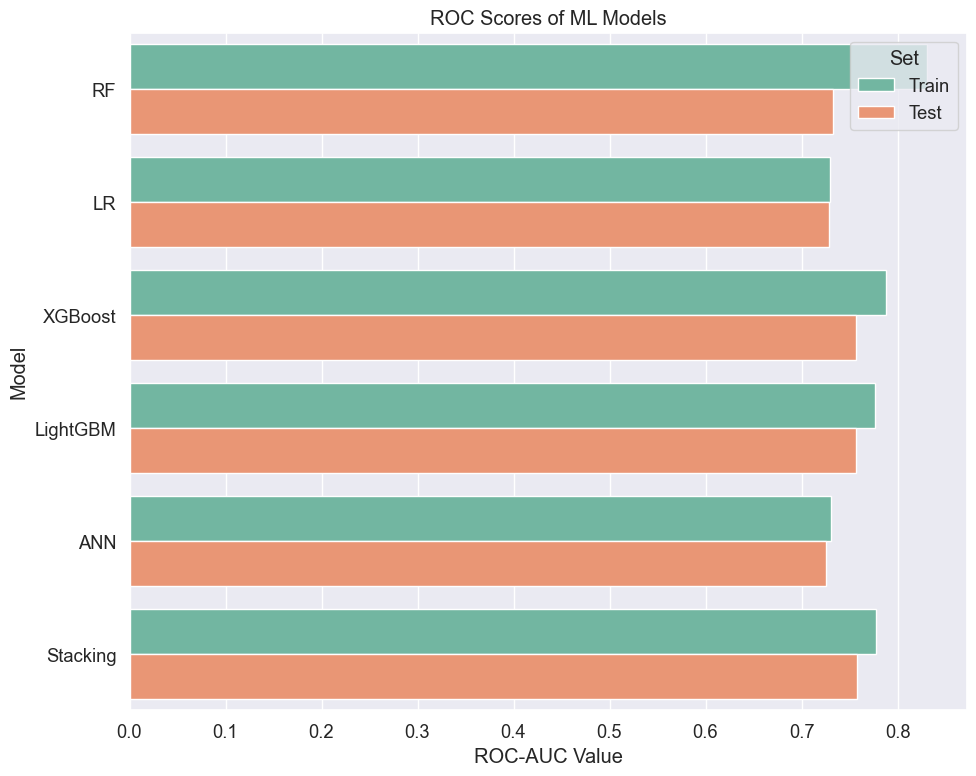

分组ROC-AUC对比图已保存


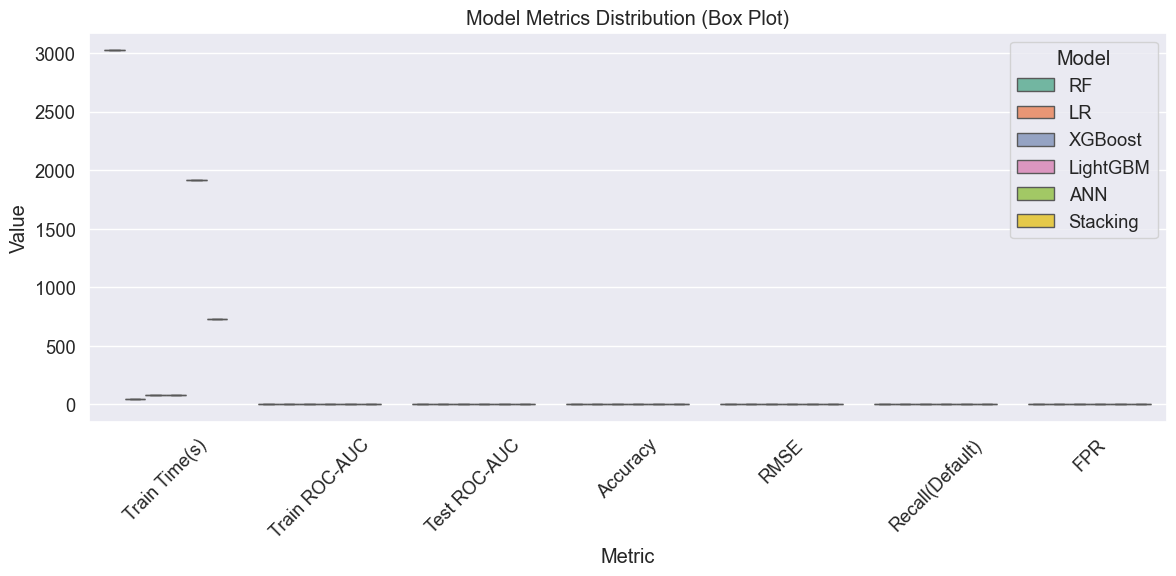

模型指标箱线图已保存


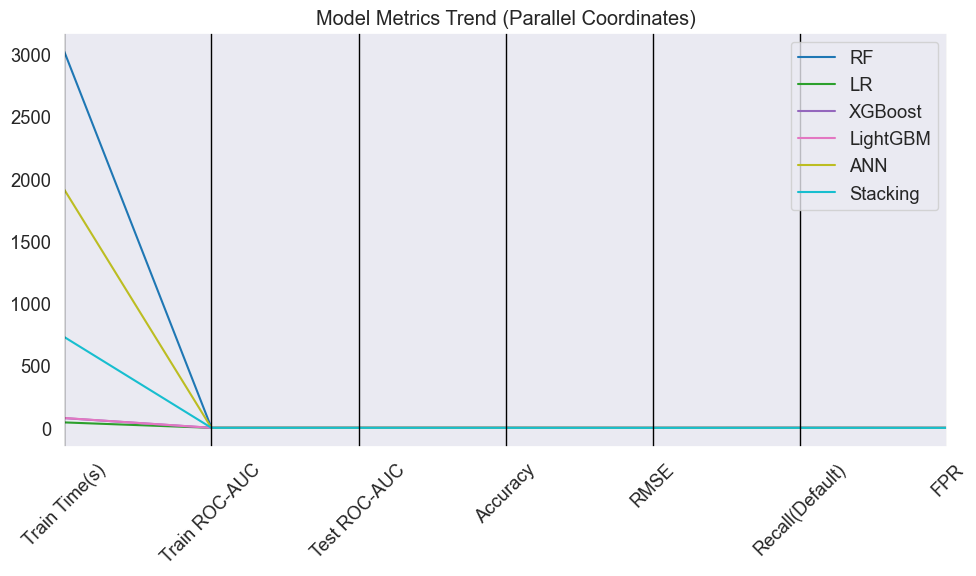

平行坐标图已保存


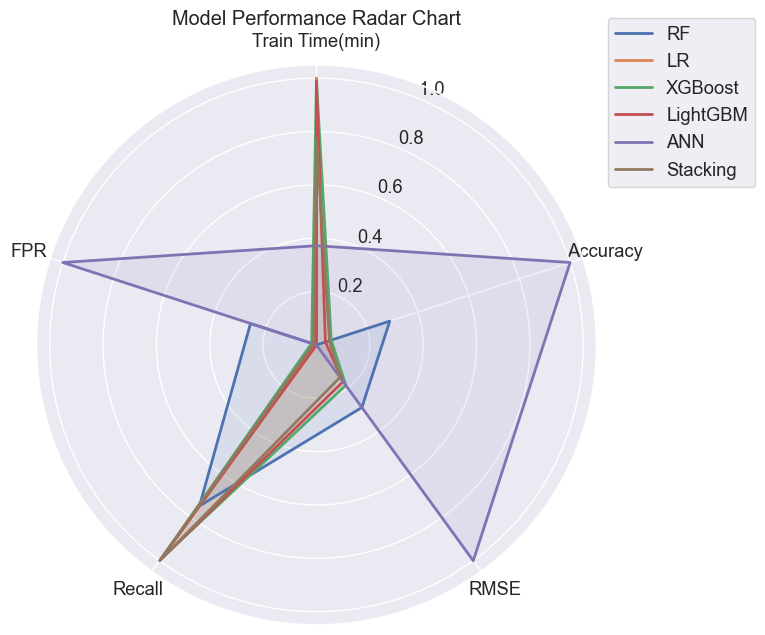

雷达图已保存


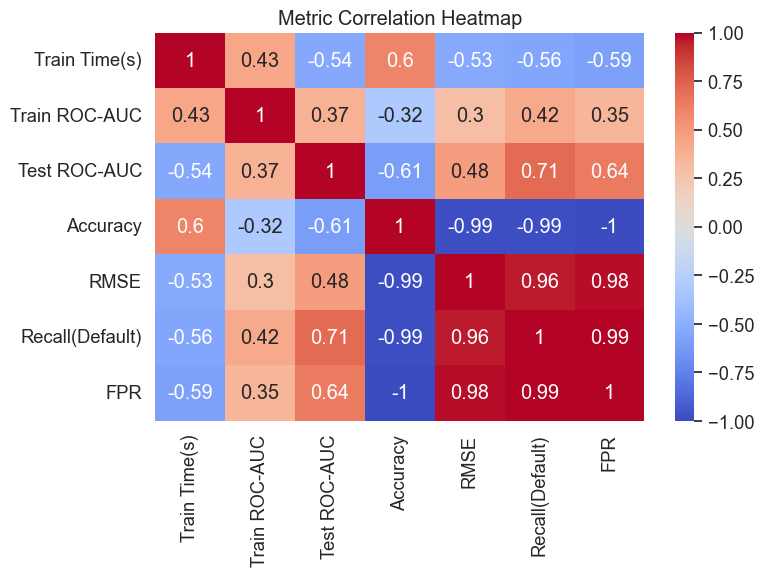

相关性热力图已保存


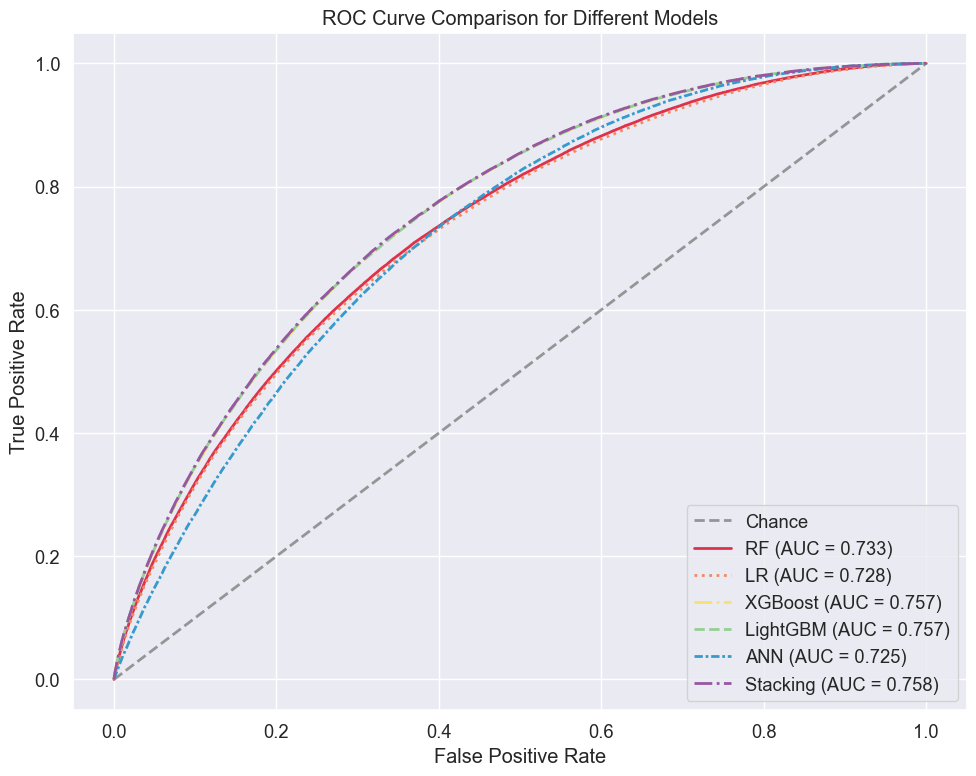

ROC曲线对比图已保存


In [70]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from pandas.plotting import parallel_coordinates
from math import pi
import os

# --------------------------
# 1. 加载模型结果
# --------------------------
def load_model_results(result_dir='results'):
    model_name_mapping = {
        'rf': 'RF',
        'linear_regression': 'LR',
        'xgb': 'XGBoost',
        'lgb': 'LightGBM',
        'ann': 'ANN',
        'stacking': 'Stacking',
    }
    all_results = {}
    for model in model_name_mapping.keys():
        pkl_path = os.path.join(result_dir, f'{model}_results.pkl')
        try:
            with open(pkl_path, 'rb') as f:
                all_results[model_name_mapping[model]] = pickle.load(f)
            print(f"成功加载模型结果: {model_name_mapping[model]}")
        except FileNotFoundError:
            print(f"警告: 未找到 {model} 的结果文件 {pkl_path}，已跳过")
    
    # 加载y_test
    try:
        with open(os.path.join(result_dir, 'y_test.pkl'), 'rb') as f:
            y_test = pickle.load(f)
    except FileNotFoundError:
        print("未找到保存的y_test，尝试从原始数据加载...")
        test_data = pd.read_csv('/Users/xumoyan/Program/anaconda3/envs/cisc7201/final report/ML/dataset/test_data_encoded.csv')
        y_test = test_data['loan_status_flag']
        with open(os.path.join(result_dir, 'y_test.pkl'), 'wb') as f:
            pickle.dump(y_test, f)
        print("已从原始数据加载y_test并保存")
    
    return all_results, y_test

# --------------------------
# 2. 可视化函数（整合多种图）
# --------------------------
def visualize_model_comparison(results, y_test):
    # 打印性能摘要
    print("\nPerformance Summary of Models:")
    print("-" * 100)
    print(f"{'Model':<15} {'Train Time(s)':<12} {'Train ROC-AUC':<12} {'Test ROC-AUC':<12} {'Accuracy':<10} {'RMSE':<8} {'Recall(Default)':<14} {'FPR'}")
    print("-" * 100)
    for model_name, result in sorted(results.items(), key=lambda x: x[1]['test_roc_auc'], reverse=True):
        print(f"{model_name:<15} {result['training_time']:<12.2f} {result['train_roc_auc']:<12.4f} "
              f"{result['test_roc_auc']:<12.4f} {result['accuracy']:<10.4f} {result['rmse']:<8.4f} "
              f"{result['tpr']:<14.4f} {result['fpr']:.4f}")
    print("-" * 100)
    
    if not results:
        print("没有模型结果可可视化！")
        return
    
    # 构造指标DataFrame
    all_metrics = []
    for model_name, result in results.items():
        metrics = {
            'Model': model_name,
            'Train Time(s)': result['training_time'],
            'Train ROC-AUC': result['train_roc_auc'],
            'Test ROC-AUC': result['test_roc_auc'],
            'Accuracy': result['accuracy'],
            'RMSE': result['rmse'],
            'Recall(Default)': result['tpr'],
            'FPR': result['fpr']
        }
        all_metrics.append(metrics)
    metrics_df = pd.DataFrame(all_metrics)

    # 1. 分组ROC-AUC条形图（原需求）
    roc_data = []
    for model_name, result in results.items():
        roc_data.append([model_name, 'Train', result['train_roc_auc']])
        roc_data.append([model_name, 'Test', result['test_roc_auc']])
    roc_df = pd.DataFrame(roc_data, columns=['Model', 'Set', 'ROC-AUC'])
    
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(x='ROC-AUC', y='Model', hue='Set', data=roc_df, palette='Set2')
    plt.title('ROC Scores of ML Models')
    plt.xlabel('ROC-AUC Value')
    plt.ylabel('Model')
    plt.tight_layout()
    plt.savefig('results/plots/model_roc_grouped_v2.png', dpi=300)
    plt.show()
    print("分组ROC-AUC对比图已保存")

    # 2. 箱线图（指标分布）
    plt.figure(figsize=(12, 6))
    melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Value')
    sns.boxplot(x='Metric', y='Value', hue='Model', data=melted, palette='Set2')
    plt.title('Model Metrics Distribution (Box Plot)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('results/plots/model_metrics_boxplot_v2.png', dpi=300)
    plt.show()
    print("模型指标箱线图已保存")

    # 3. 平行坐标图（多指标趋势）
    plt.figure(figsize=(10, 6))
    parallel_coordinates(metrics_df, 'Model', color=plt.cm.tab10(np.linspace(0, 1, len(results))))
    plt.title('Model Metrics Trend (Parallel Coordinates)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('results/plots/model_metrics_parallel_v2.png', dpi=300)
    plt.show()
    print("平行坐标图已保存")

    # 4. 雷达图（综合性能）
    # 指标归一化，便于雷达图展示
    radar_metrics = ['training_time', 'accuracy', 'rmse', 'tpr', 'fpr']
    categories = ['Train Time(min)', 'Accuracy', 'RMSE', 'Recall', 'FPR']
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # 闭合

    # 归一化方向：训练时间/误差/FPR越小越好，准确率/Recall越大越好
    norm_metrics = {}
    for metric in radar_metrics:
        values = [results[m][metric] for m in results]
        if metric in ['training_time', 'rmse', 'fpr']:
            # 反向归一化（越小越好）
            norm = (np.max(values) - np.array(values)) / (np.max(values) - np.min(values) + 1e-8)
        else:
            # 正向归一化（越大越好）
            norm = (np.array(values) - np.min(values)) / (np.max(values) - np.min(values) + 1e-8)
        norm_metrics[metric] = norm

    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    for idx, model_name in enumerate(results.keys()):
        values = [
            norm_metrics['training_time'][idx],
            norm_metrics['accuracy'][idx],
            norm_metrics['rmse'][idx],
            norm_metrics['tpr'][idx],
            norm_metrics['fpr'][idx]
        ]
        values += values[:1]  # 闭合
        ax.plot(angles, values, linewidth=2, label=model_name)
        ax.fill(angles, values, alpha=0.1)

    plt.xticks(angles[:-1], categories)
    plt.title('Model Performance Radar Chart')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.savefig('results/plots/model_metrics_radar_v2.png', dpi=300)
    plt.show()
    print("雷达图已保存")

    # 5. 相关性热力图（指标关联）
    corr = metrics_df.drop('Model', axis=1).corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Metric Correlation Heatmap')
    plt.tight_layout()
    plt.savefig('results/plots/model_metrics_correlation_v2.png', dpi=300)
    plt.show()
    print("相关性热力图已保存")

    # 6. ROC曲线对比（原功能增强）
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Chance', alpha=.8)
    line_styles = {
        'RF': '-',
        'LR': ':',
        'XGBoost': '-.',
        'LightGBM': '--',
        'ANN': (0, (3, 1, 1, 1)),
        'Stacking': '-.'
    }
    line_colors = {
        'RF': "#de324c",
        'LR': '#f4895f',
        'XGBoost': "#f8e16f",
        'LightGBM': "#95cf92",
        'ANN': '#369acc',
        'Stacking': "#9656a2"
    }
    
    for model_name, result in results.items():
        if 'y_pred_proba' in result:
            fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})', 
                     linestyle=line_styles[model_name], color=line_colors[model_name])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison for Different Models')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('results/plots/model_roc_curve_comparison_v2.png', dpi=300)
    plt.show()
    print("ROC曲线对比图已保存")

if __name__ == "__main__":
    all_results, y_test = load_model_results()
    save_results_to_txt(all_results)
    visualize_model_comparison(all_results, y_test)



成功加载模型结果: RF
成功加载模型结果: LR
成功加载模型结果: XGBoost
成功加载模型结果: LightGBM
成功加载模型结果: ANN

Performance Summary of Models:
----------------------------------------------------------------------------------------------------
Model           Train Time(s) Train ROC-AUC Test ROC-AUC Accuracy   RMSE     Recall(Default) FPR
----------------------------------------------------------------------------------------------------
LightGBM        79.62        0.7765       0.7571       0.6825     0.4406   0.6931         0.3190
XGBoost         78.71        0.7878       0.7571       0.6856     0.4390   0.6902         0.3150
RF              3023.28      0.8306       0.7325       0.7169     0.4293   0.5911         0.2646
LR              44.25        0.7295       0.7282       0.6777     0.4567   0.6487         0.3180
ANN             1914.72      0.7307       0.7253       0.8134     0.3622   0.2893         0.1094
----------------------------------------------------------------------------------------------------


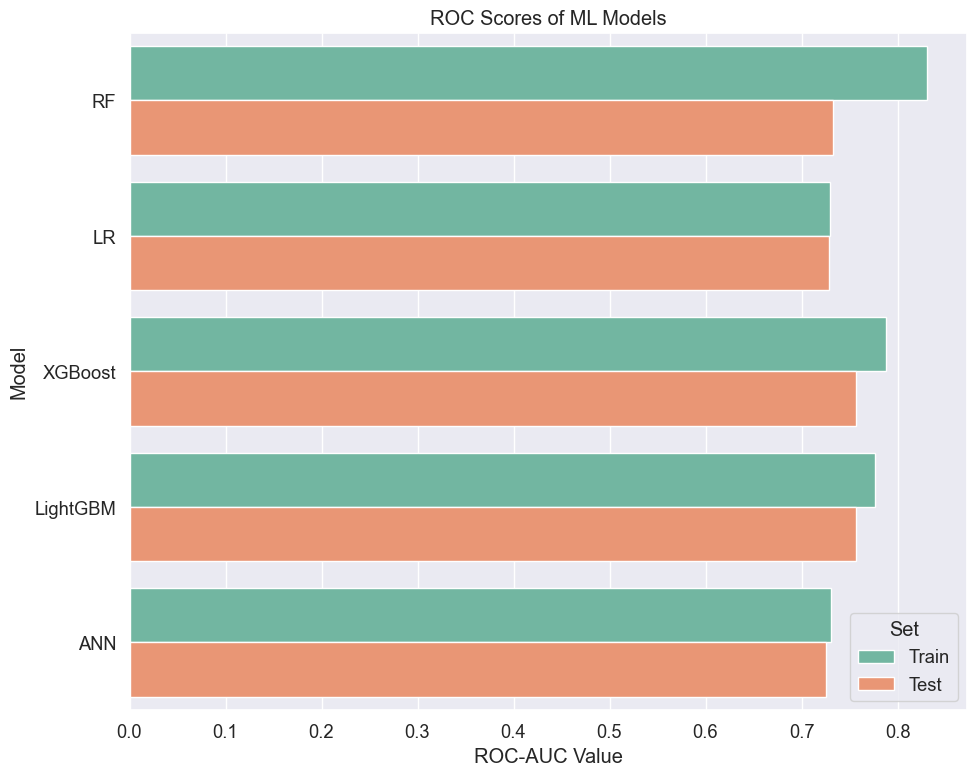

分组ROC-AUC对比图已保存


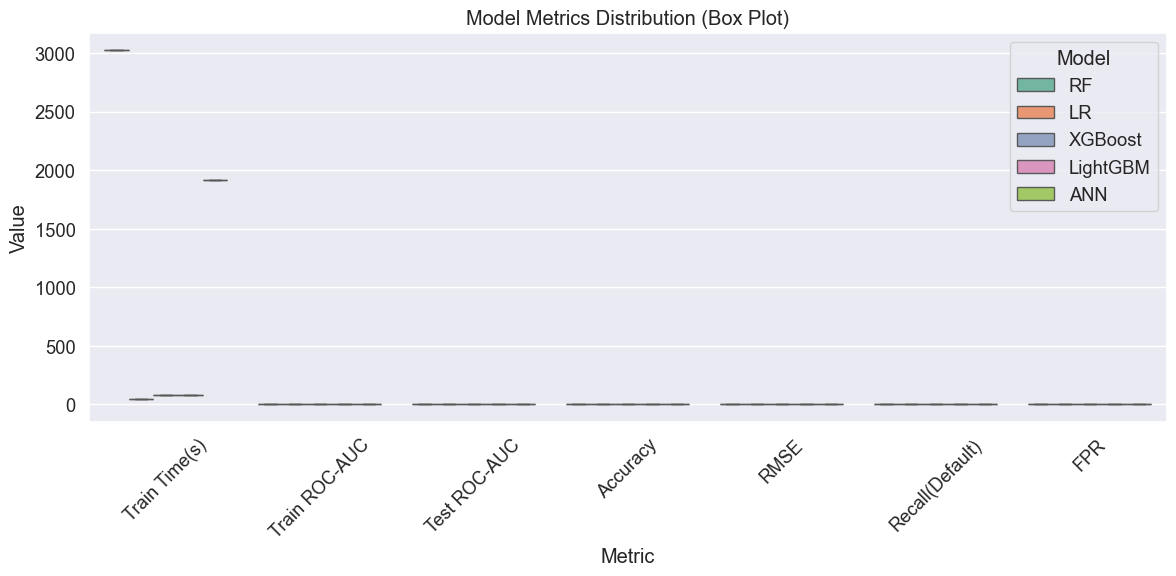

模型指标箱线图已保存


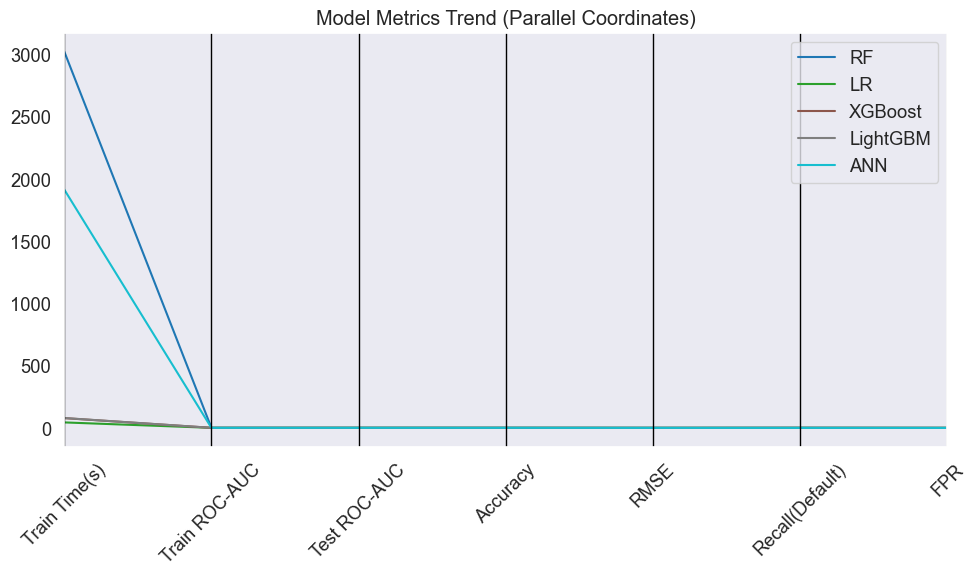

平行坐标图已保存


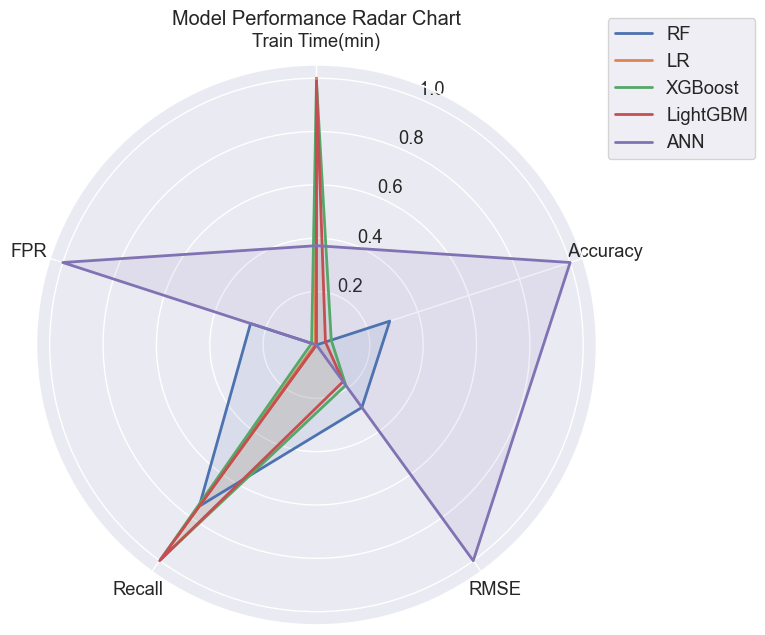

雷达图已保存


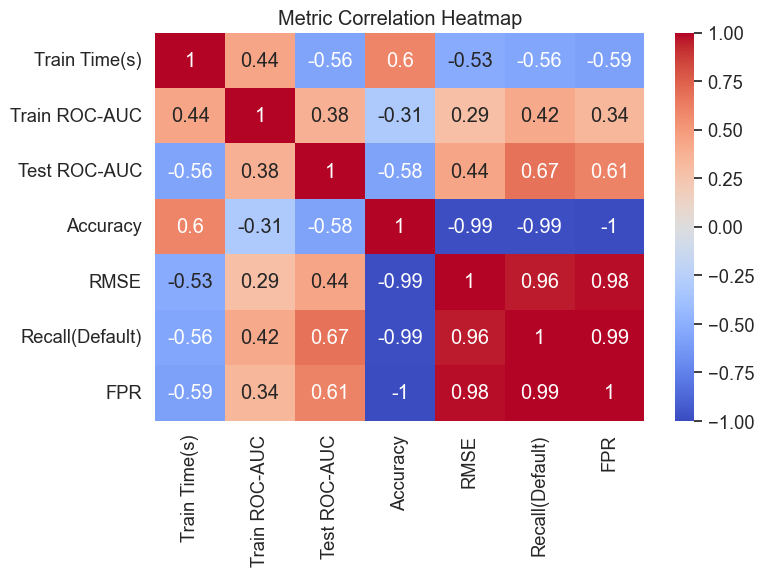

相关性热力图已保存


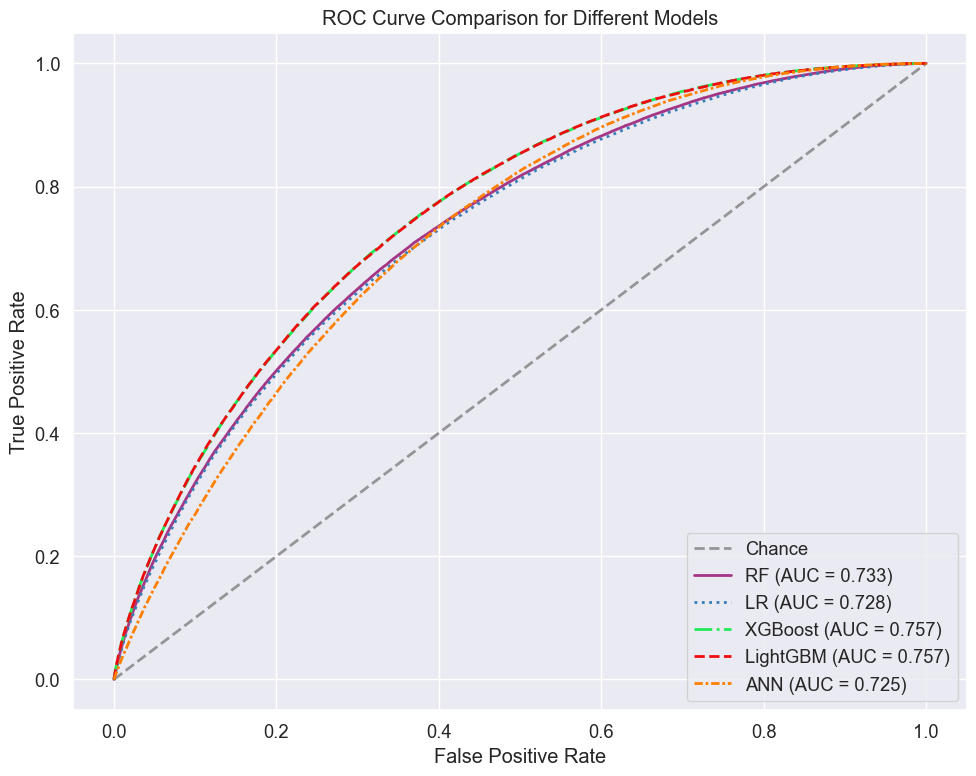

ROC曲线对比图已保存


In [60]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from pandas.plotting import parallel_coordinates
from math import pi
import os

# --------------------------
# 1. 加载模型结果
# --------------------------
def load_model_results(result_dir='results'):
    model_name_mapping = {
        'rf': 'RF',
        'linear_regression': 'LR',
        'xgb': 'XGBoost',
        'lgb': 'LightGBM',
        'ann': 'ANN'
    }
    all_results = {}
    for model in model_name_mapping.keys():
        pkl_path = os.path.join(result_dir, f'{model}_results.pkl')
        try:
            with open(pkl_path, 'rb') as f:
                all_results[model_name_mapping[model]] = pickle.load(f)
            print(f"成功加载模型结果: {model_name_mapping[model]}")
        except FileNotFoundError:
            print(f"警告: 未找到 {model} 的结果文件 {pkl_path}，已跳过")
    
    # 加载y_test
    try:
        with open(os.path.join(result_dir, 'y_test.pkl'), 'rb') as f:
            y_test = pickle.load(f)
    except FileNotFoundError:
        print("未找到保存的y_test，尝试从原始数据加载...")
        test_data = pd.read_csv('/Users/xumoyan/Program/anaconda3/envs/cisc7201/final report/ML/dataset/test_data_encoded.csv')
        y_test = test_data['loan_status_flag']
        with open(os.path.join(result_dir, 'y_test.pkl'), 'wb') as f:
            pickle.dump(y_test, f)
        print("已从原始数据加载y_test并保存")
    
    return all_results, y_test

# --------------------------
# 2. 可视化函数（整合多种图）
# --------------------------
def visualize_model_comparison(results, y_test):
    # 打印性能摘要
    print("\nPerformance Summary of Models:")
    print("-" * 100)
    print(f"{'Model':<15} {'Train Time(s)':<12} {'Train ROC-AUC':<12} {'Test ROC-AUC':<12} {'Accuracy':<10} {'RMSE':<8} {'Recall(Default)':<14} {'FPR'}")
    print("-" * 100)
    for model_name, result in sorted(results.items(), key=lambda x: x[1]['test_roc_auc'], reverse=True):
        print(f"{model_name:<15} {result['training_time']:<12.2f} {result['train_roc_auc']:<12.4f} "
              f"{result['test_roc_auc']:<12.4f} {result['accuracy']:<10.4f} {result['rmse']:<8.4f} "
              f"{result['tpr']:<14.4f} {result['fpr']:.4f}")
    print("-" * 100)
    
    if not results:
        print("没有模型结果可可视化！")
        return
    
    # 构造指标DataFrame
    all_metrics = []
    for model_name, result in results.items():
        metrics = {
            'Model': model_name,
            'Train Time(s)': result['training_time'],
            'Train ROC-AUC': result['train_roc_auc'],
            'Test ROC-AUC': result['test_roc_auc'],
            'Accuracy': result['accuracy'],
            'RMSE': result['rmse'],
            'Recall(Default)': result['tpr'],
            'FPR': result['fpr']
        }
        all_metrics.append(metrics)
    metrics_df = pd.DataFrame(all_metrics)

    # 1. 分组ROC-AUC条形图（原需求）
    roc_data = []
    for model_name, result in results.items():
        roc_data.append([model_name, 'Train', result['train_roc_auc']])
        roc_data.append([model_name, 'Test', result['test_roc_auc']])
    roc_df = pd.DataFrame(roc_data, columns=['Model', 'Set', 'ROC-AUC'])
    
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(x='ROC-AUC', y='Model', hue='Set', data=roc_df, palette='Set2')
    plt.title('ROC Scores of ML Models')
    plt.xlabel('ROC-AUC Value')
    plt.ylabel('Model')
    plt.tight_layout()
    plt.savefig('results/plots/model_roc_grouped.png', dpi=300)
    plt.show()
    print("分组ROC-AUC对比图已保存")

    # 2. 箱线图（指标分布）
    plt.figure(figsize=(12, 6))
    melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Value')
    sns.boxplot(x='Metric', y='Value', hue='Model', data=melted, palette='Set2')
    plt.title('Model Metrics Distribution (Box Plot)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('results/plots/model_metrics_boxplot.png', dpi=300)
    plt.show()
    print("模型指标箱线图已保存")

    # 3. 平行坐标图（多指标趋势）
    plt.figure(figsize=(10, 6))
    parallel_coordinates(metrics_df, 'Model', color=plt.cm.tab10(np.linspace(0, 1, len(results))))
    plt.title('Model Metrics Trend (Parallel Coordinates)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('results/plots/model_metrics_parallel.png', dpi=300)
    plt.show()
    print("平行坐标图已保存")

    # 4. 雷达图（综合性能）
    # 指标归一化，便于雷达图展示
    radar_metrics = ['training_time', 'accuracy', 'rmse', 'tpr', 'fpr']
    categories = ['Train Time(min)', 'Accuracy', 'RMSE', 'Recall', 'FPR']
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # 闭合

    # 归一化方向：训练时间/误差/FPR越小越好，准确率/Recall越大越好
    norm_metrics = {}
    for metric in radar_metrics:
        values = [results[m][metric] for m in results]
        if metric in ['training_time', 'rmse', 'fpr']:
            # 反向归一化（越小越好）
            norm = (np.max(values) - np.array(values)) / (np.max(values) - np.min(values) + 1e-8)
        else:
            # 正向归一化（越大越好）
            norm = (np.array(values) - np.min(values)) / (np.max(values) - np.min(values) + 1e-8)
        norm_metrics[metric] = norm

    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    for idx, model_name in enumerate(results.keys()):
        values = [
            norm_metrics['training_time'][idx],
            norm_metrics['accuracy'][idx],
            norm_metrics['rmse'][idx],
            norm_metrics['tpr'][idx],
            norm_metrics['fpr'][idx]
        ]
        values += values[:1]  # 闭合
        ax.plot(angles, values, linewidth=2, label=model_name)
        ax.fill(angles, values, alpha=0.1)

    plt.xticks(angles[:-1], categories)
    plt.title('Model Performance Radar Chart')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.savefig('results/plots/model_metrics_radar.png', dpi=300)
    plt.show()
    print("雷达图已保存")

    # 5. 相关性热力图（指标关联）
    corr = metrics_df.drop('Model', axis=1).corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Metric Correlation Heatmap')
    plt.tight_layout()
    plt.savefig('results/plots/model_metrics_correlation.png', dpi=300)
    plt.show()
    print("相关性热力图已保存")

    # 6. ROC曲线对比（原功能增强）
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Chance', alpha=.8)
    line_styles = {
        'RF': '-',
        'LR': ':',
        'XGBoost': '-.',
        'LightGBM': '--',
        'ANN': (0, (3, 1, 1, 1))
    }
    line_colors = {
        'RF': "#a53585",
        'LR': '#377eb8',
        'XGBoost': "#23ea58",
        'LightGBM': "#ef0c10",
        'ANN': '#ff7f00'
    }
    
    for model_name, result in results.items():
        if 'y_pred_proba' in result:
            fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})', 
                     linestyle=line_styles[model_name], color=line_colors[model_name])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison for Different Models')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('results/plots/model_roc_curve_comparison.png', dpi=300)
    plt.show()
    print("ROC曲线对比图已保存")

if __name__ == "__main__":
    all_results, y_test = load_model_results()
    save_results_to_txt(all_results)
    visualize_model_comparison(all_results, y_test)




Performance Summary of Models:
----------------------------------------------------------------------------------------------------
Model           Train Time(s) Train ROC-AUC Test ROC-AUC Accuracy   RMSE     Recall(Default) FPR
----------------------------------------------------------------------------------------------------
LightGBM        70.50        0.7765       0.7571       0.6825     0.4406   0.6931         0.3190
XGBoost         78.71        0.7878       0.7571       0.6856     0.4390   0.6902         0.3150
RandomForest    3023.28      0.8306       0.7325       0.7169     0.4293   0.5911         0.2646
Linear Regression 44.25        0.7295       0.7282       0.6777     0.4567   0.6487         0.3180
ANN             1914.72      0.7307       0.7253       0.8134     0.3622   0.2893         0.1094
----------------------------------------------------------------------------------------------------


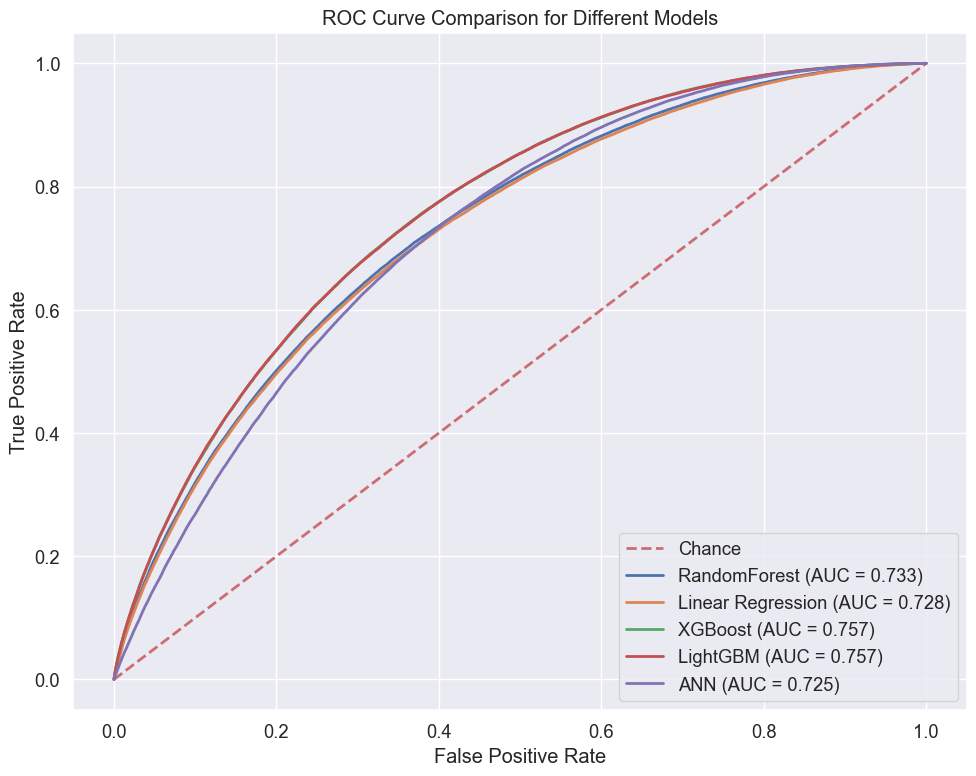

成功加载模型结果: RandomForest
成功加载模型结果: Linear Regression
成功加载模型结果: XGBoost
成功加载模型结果: LightGBM
成功加载模型结果: ANN

Performance Summary of Models:
----------------------------------------------------------------------------------------------------
Model           Train Time(s) Train ROC-AUC Test ROC-AUC Accuracy   RMSE     Recall(Default) FPR
----------------------------------------------------------------------------------------------------
LightGBM        70.50        0.7765       0.7571       0.6825     0.4406   0.6931         0.3190
XGBoost         78.71        0.7878       0.7571       0.6856     0.4390   0.6902         0.3150
RandomForest    3023.28      0.8306       0.7325       0.7169     0.4293   0.5911         0.2646
Linear Regression 44.25        0.7295       0.7282       0.6777     0.4567   0.6487         0.3180
ANN             1914.72      0.7307       0.7253       0.8134     0.3622   0.2893         0.1094
--------------------------------------------------------------------------------

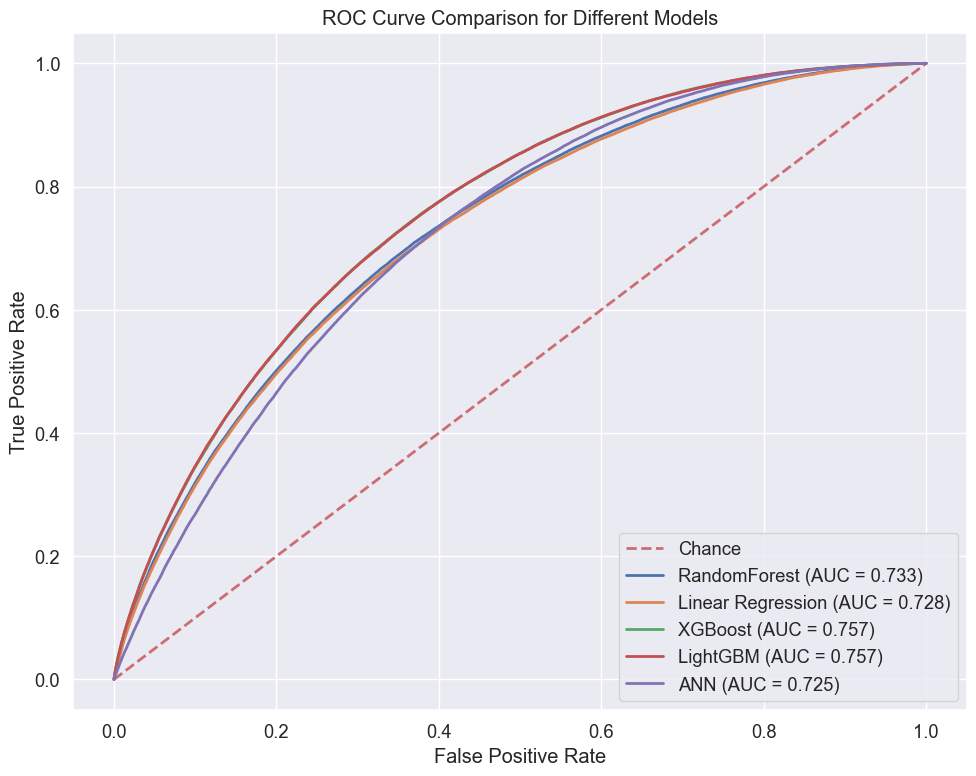

In [41]:
def visualize_model_comparison(results, y_test):
    """Visualize performance comparison among different models"""
    print("\nPerformance Summary of Models:")
    print("-" * 100)
    print(f"{'Model':<15} {'Train Time(s)':<12} {'Train ROC-AUC':<12} {'Test ROC-AUC':<12} {'Accuracy':<10} {'RMSE':<8} {'Recall(Default)':<14} {'FPR'}")
    print("-" * 100)

    for model_name, result in sorted(results.items(), key=lambda x: x[1]['test_roc_auc'], reverse=True):
        print(f"{model_name:<15} {result['training_time']:<12.2f} {result['train_roc_auc']:<12.4f} "
              f"{result['test_roc_auc']:<12.4f} {result['accuracy']:<10.4f} {result['rmse']:<8.4f} "
              f"{result['tpr']:<14.4f} {result['fpr']:.4f}")
    print("-" * 100)
    
    # Visualize model performance
    plt.figure(figsize=(18, 6))
    
    # ROC-AUC and Accuracy comparison
    plt.subplot(1, 3, 1)
    metrics_data = pd.DataFrame({
        'Model': list(results.keys()),
        'ROC-AUC': [results[k]['test_roc_auc'] for k in results],
        'Accuracy': [results[k]['accuracy'] for k in results]
    })
    metrics_data = metrics_data.melt(id_vars='Model', var_name='Metric', value_name='Score')
    ax1 = sns.barplot(x='Score', y='Model', hue='Metric', data=metrics_data)
    plt.title('ROC-AUC and Accuracy Comparison')
    # 使用Seaborn自动生成的标签创建图例
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, title='Metric', loc='lower right')
    
    # Recall and FPR comparison
    plt.subplot(1, 3, 2)
    error_data = pd.DataFrame({
        'Model': list(results.keys()),
        'Recall(Default)': [results[k]['tpr'] for k in results],
        'FPR': [results[k]['fpr'] for k in results]
    })
    error_data = error_data.melt(id_vars='Model', var_name='Metric', value_name='Score')
    ax2 = sns.barplot(x='Score', y='Model', hue='Metric', data=error_data)
    plt.title('Recall(Default) and FPR Comparison')
    # 使用Seaborn自动生成的标签创建图例
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels, title='Metric', loc='lower right')
    plt.xlabel('Score')
    
    # RMSE comparison
    plt.subplot(1, 3, 3)
    rmse_data = pd.DataFrame({
        'Model': list(results.keys()),
        'RMSE': [results[k]['rmse'] for k in results]
    })
    sns.barplot(x='RMSE', y='Model', data=rmse_data)
    plt.title('RMSE Comparison')
    
    plt.tight_layout()
    # 确保目录存在（如果不存在会报错）
    plt.savefig('results/plots/model_comparison.png', dpi=300)
    plt.close()
    
    # Plot ROC curves for all models
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    
    for model_name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison for Different Models')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('results/plots/model_roc_curve_comparison.png', dpi=300)
    plt.show()

# Save results to text files
def save_results_to_txt(results):
    """Save numerical results to text file"""
    with open('results/text/model_comparison_summary.txt', 'w') as f:
        f.write("Performance Summary of Models:\n")
        f.write("-" * 100 + "\n")
        f.write(f"{'Model':<15} {'Train Time(s)':<12} {'Train ROC-AUC':<12} {'Test ROC-AUC':<12} {'Accuracy':<10} "
                f"{'RMSE':<8} {'Recall(Default)':<14} {'FPR'}\n")
        f.write("-" * 100 + "\n")

        for model_name, result in sorted(results.items(), key=lambda x: x[1]['test_roc_auc'], reverse=True):
            f.write(f"{model_name:<15} {result['training_time']:<12.2f}{result['train_roc_auc']:<12.4f} "
                    f"{result['test_roc_auc']:<12.4f} {result['accuracy']:<10.4f} {result['rmse']:<8.4f} "
                    f"{result['tpr']:<14.4f} {result['fpr']:.4f}\n")
        f.write("-" * 80 + "\n")
        
        # Save detailed metrics for each model
        f.write("\nDetailed Metrics for Each Model:\n")
        for model_name, result in results.items():
            f.write(f"\n{model_name}:\n")
            f.write(f"  Best Parameters: {result['best_params']}\n")
            f.write(f"  Training Time: {result['training_time']:.2f} seconds\n")
            f.write(f"  Training ROC-AUC: {result['train_roc_auc']:.4f}\n")
            f.write(f"  Testing ROC-AUC: {result['test_roc_auc']:.4f}\n")
            f.write(f"  Accuracy: {result['accuracy']:.4f}\n")
            f.write(f"  RMSE: {result['rmse']:.4f}\n")
            f.write(f"  Recall for Default Class (TPR): {result['tpr']:.4f}\n")
            f.write(f"  False Positive Rate (FPR): {result['fpr']:.4f}\n")
            
            # Save confusion matrix
            cm = result['confusion_matrix']
            f.write("  Confusion Matrix:\n")
            f.write(f"    True Negatives: {cm[0, 0]}\n")
            f.write(f"    False Positives: {cm[0, 1]}\n")
            f.write(f"    False Negatives: {cm[1, 0]}\n")
            f.write(f"    True Positives: {cm[1, 1]}\n")

# Run comparison
save_results_to_txt(all_results)

# Save all reports
for model_name, report in all_reports.items():
    with open(f'results/text/{model_name}_classification_report.txt', 'w') as f:
        f.write(f"{model_name} Classification Report:\n")
        f.write("-" * 50 + "\n")
        f.write(report)

# Save all results to pickle
with open('results/all_model_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)

# Visualize comparison
visualize_model_comparison(all_results, y_test)

if __name__ == "__main__":
    all_results, y_test = load_model_results()
    save_results_to_txt(all_results)
    visualize_model_comparison(all_results, y_test)

# SHAP

Note: you may need to restart the kernel to use updated packages.


Starting SHAP Analysis for all models...

Analyzing XGBoost...

SHAP Analysis for XGBoost


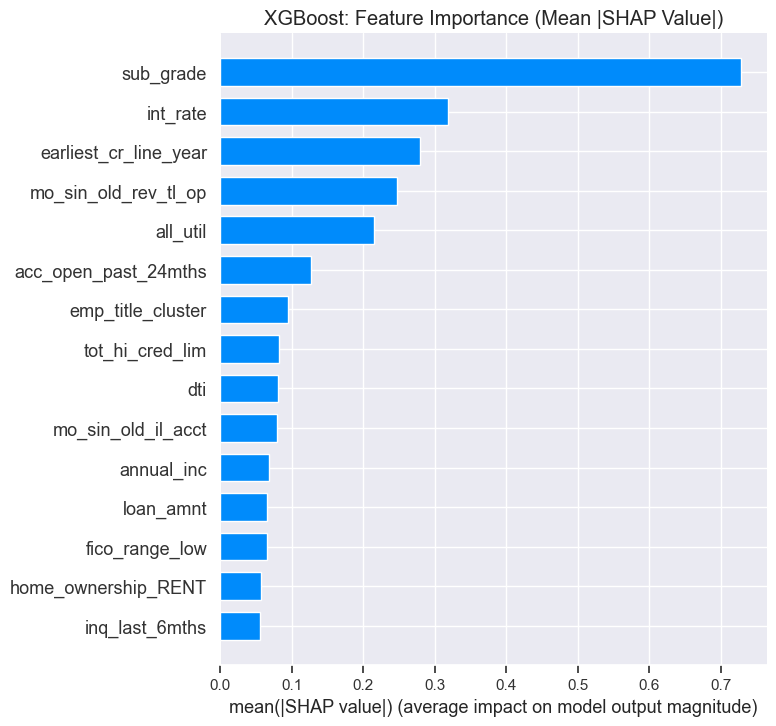

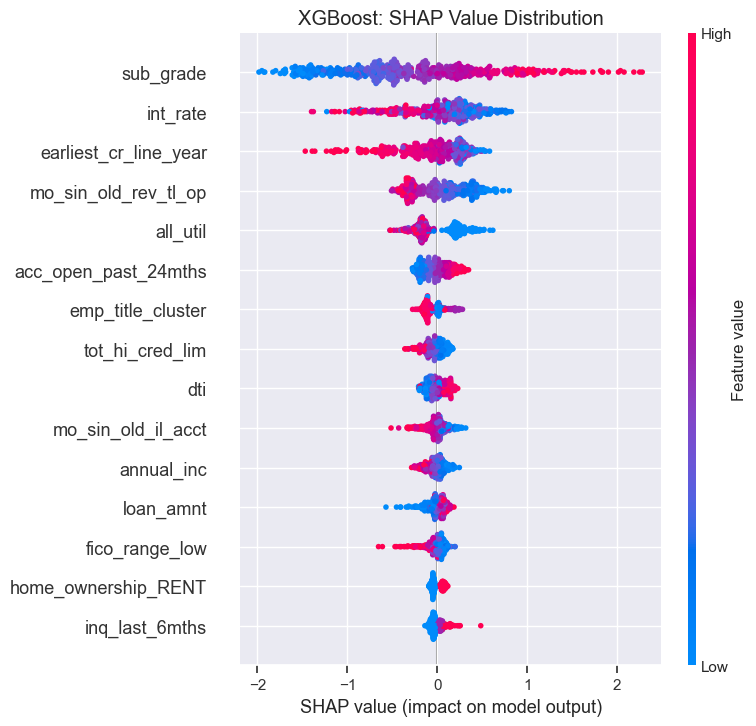

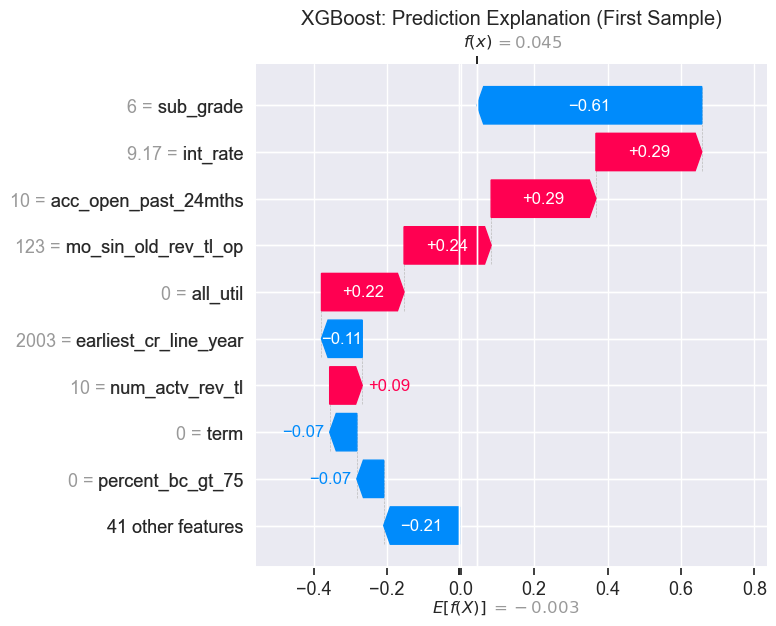

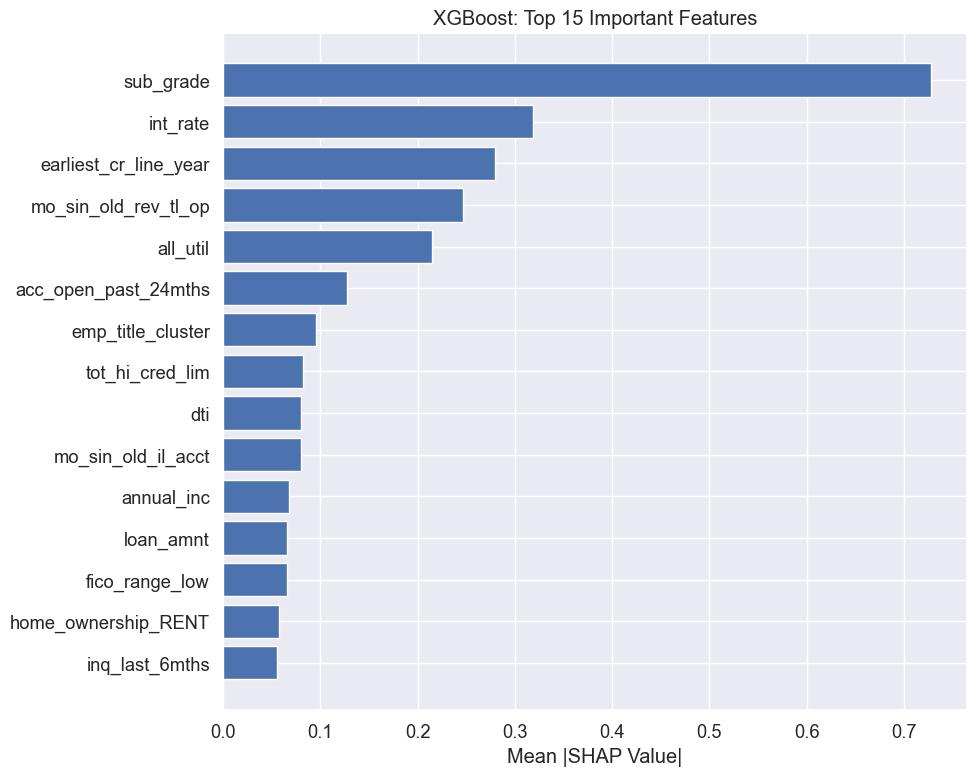

<Figure size 1000x600 with 0 Axes>

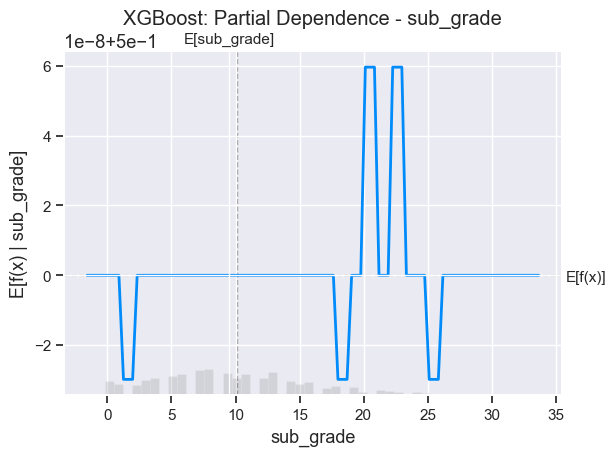

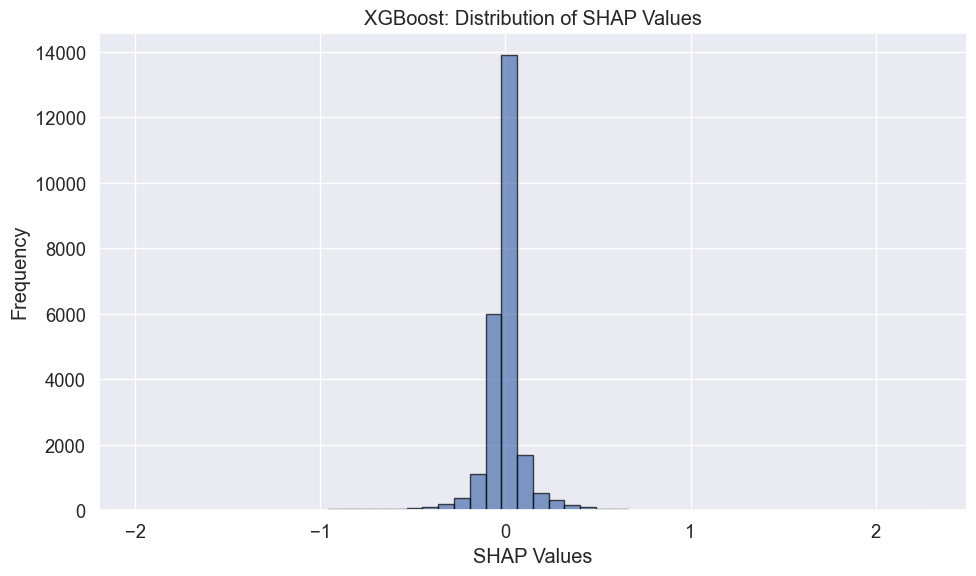


Top 10 Important Features for XGBoost:
              feature  mean_shap_importance  mean_shap_value
            sub_grade              0.728334        -0.260302
             int_rate              0.318315         0.025867
earliest_cr_line_year              0.279092        -0.075540
 mo_sin_old_rev_tl_op              0.246647         0.036848
             all_util              0.215109        -0.017772
 acc_open_past_24mths              0.126941        -0.019392
    emp_title_cluster              0.094948        -0.059873
      tot_hi_cred_lim              0.081603        -0.018307
                  dti              0.080290        -0.006930
   mo_sin_old_il_acct              0.079898        -0.008380

Analyzing LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 203066, number of negative: 1378870
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070022 seconds.
You can 

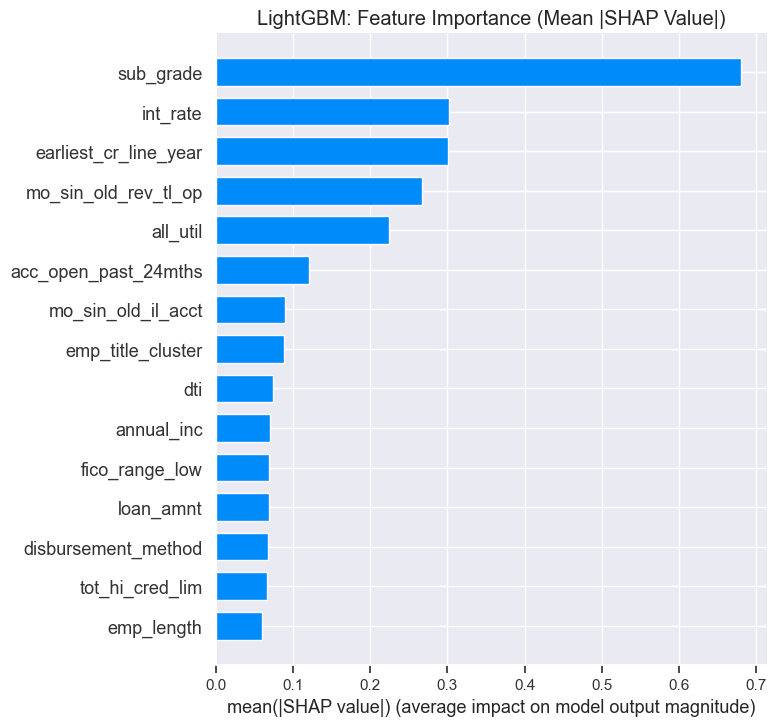

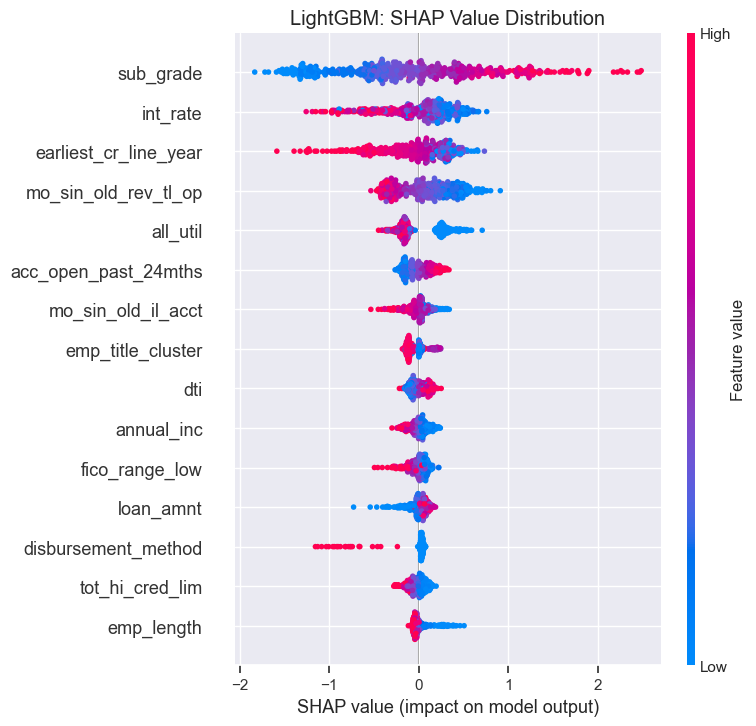

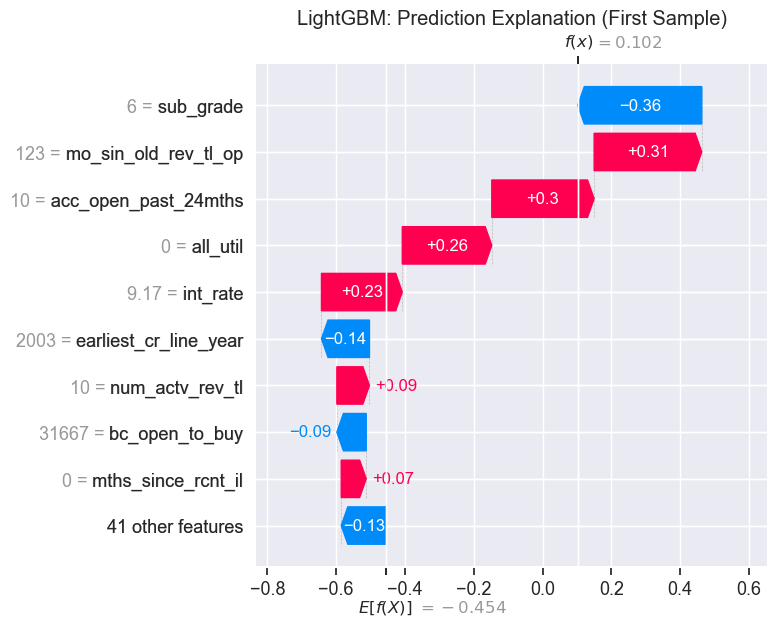

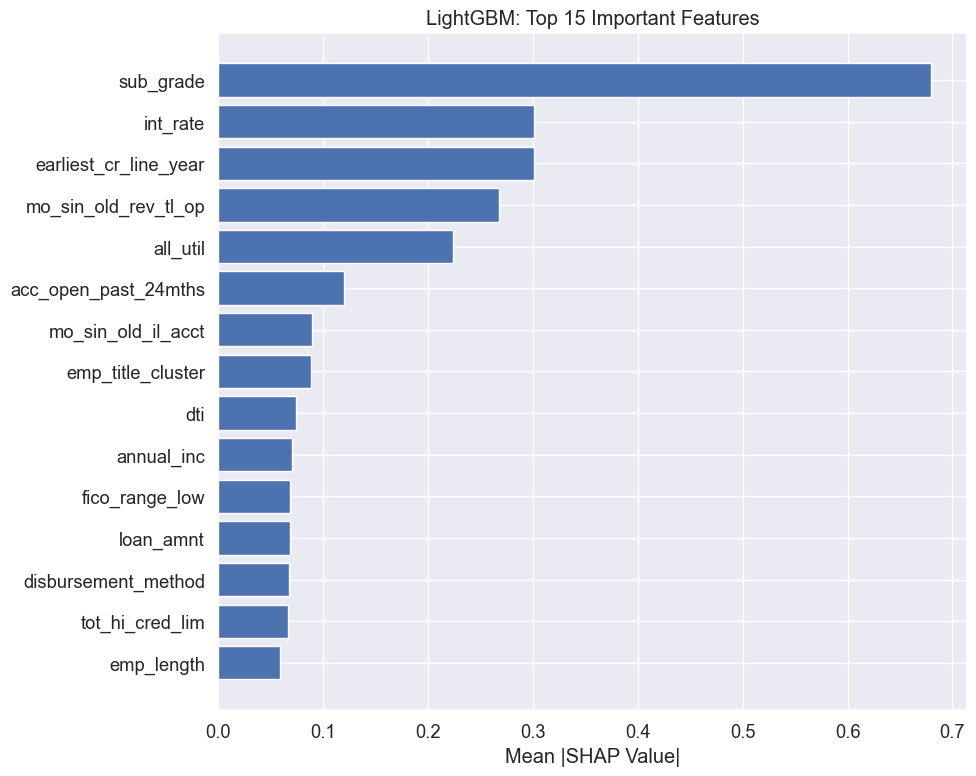

<Figure size 1000x600 with 0 Axes>

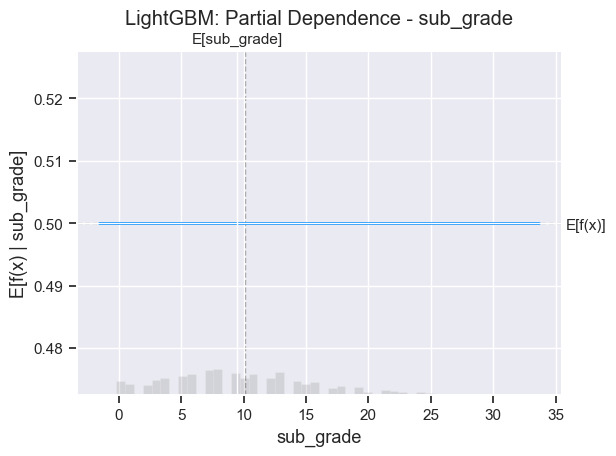

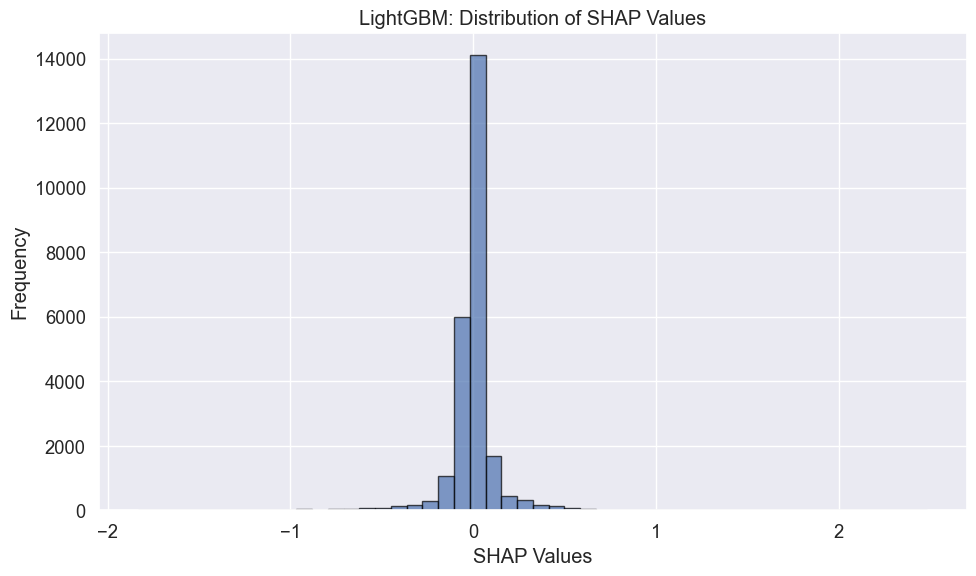


Top 10 Important Features for LightGBM:
              feature  mean_shap_importance  mean_shap_value
            sub_grade              0.679694        -0.027760
             int_rate              0.301429         0.004201
earliest_cr_line_year              0.300544        -0.052858
 mo_sin_old_rev_tl_op              0.267539         0.061185
             all_util              0.224129         0.012902
 acc_open_past_24mths              0.120246        -0.003910
   mo_sin_old_il_acct              0.089135        -0.009345
    emp_title_cluster              0.088393        -0.056511
                  dti              0.073989         0.004215
           annual_inc              0.070075         0.001390

Analyzing Logistic Regression...

SHAP Analysis for LogisticRegression


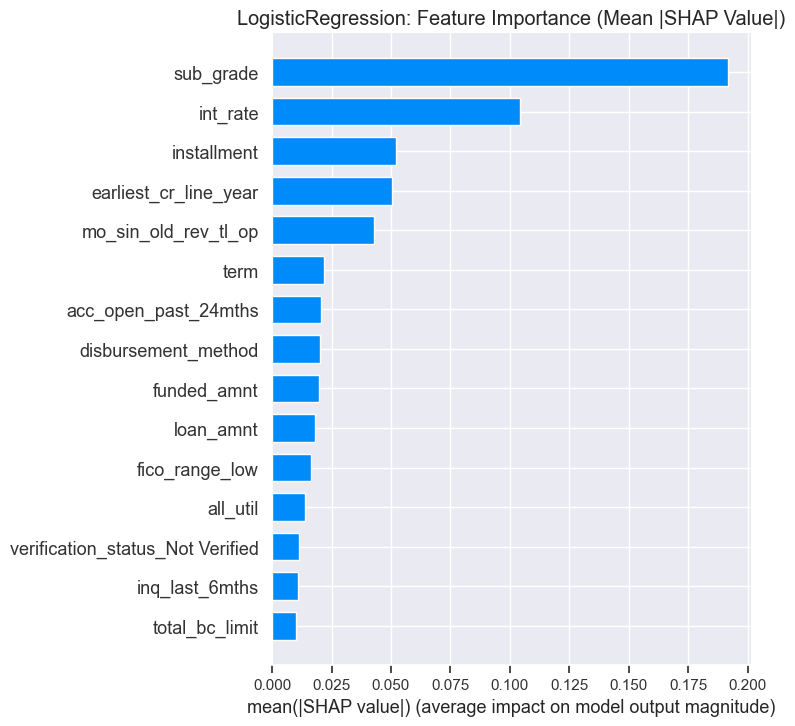

Error in Logistic Regression SHAP analysis: Feature and SHAP matrices must have the same number of rows!

SHAP analysis completed for 2 models.

Comparing SHAP importance across models...


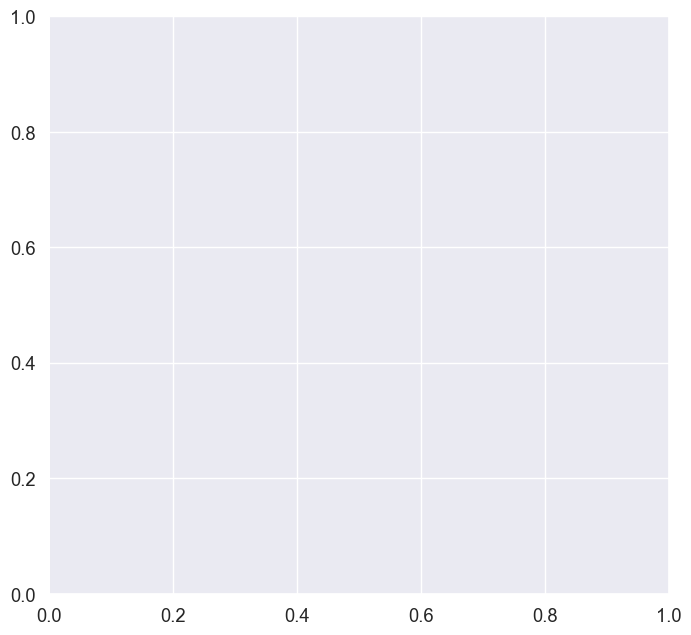

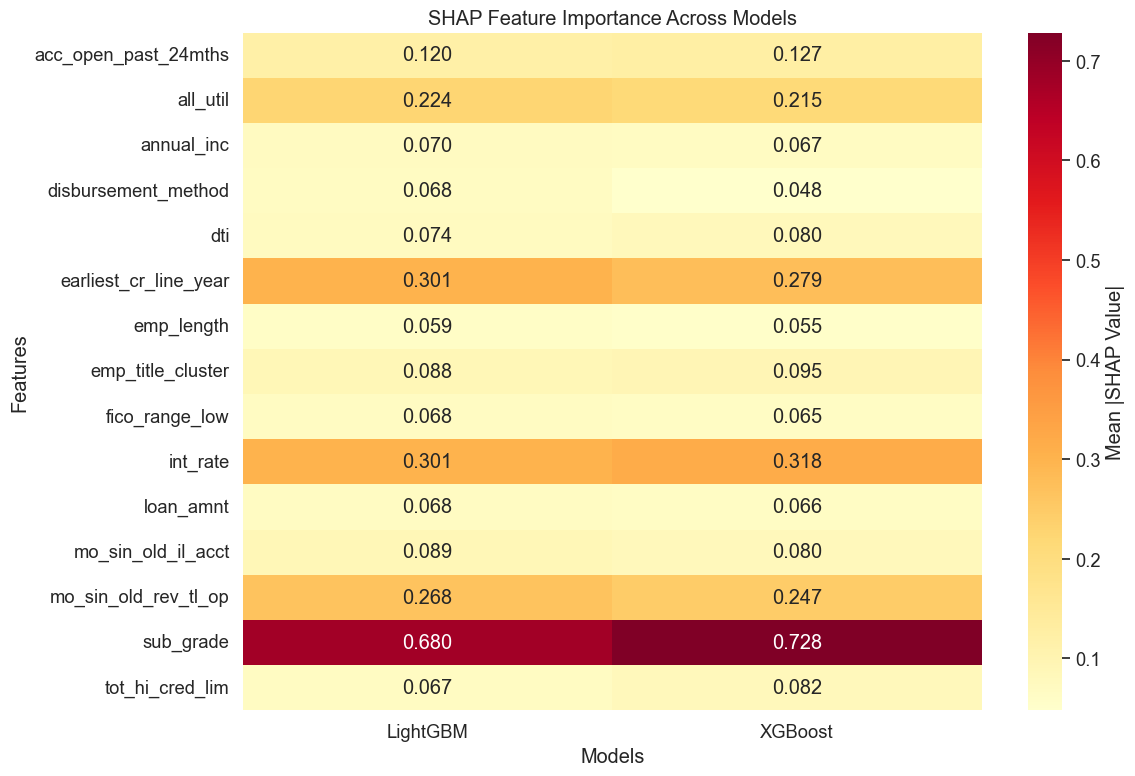

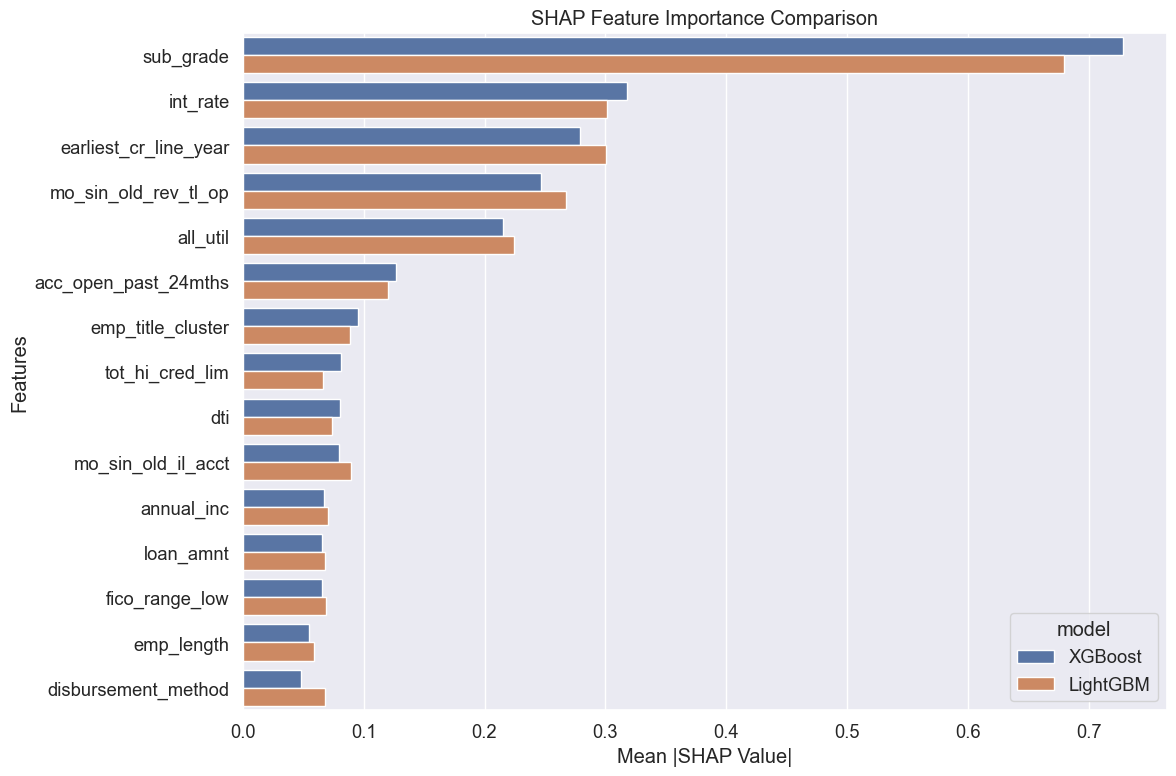

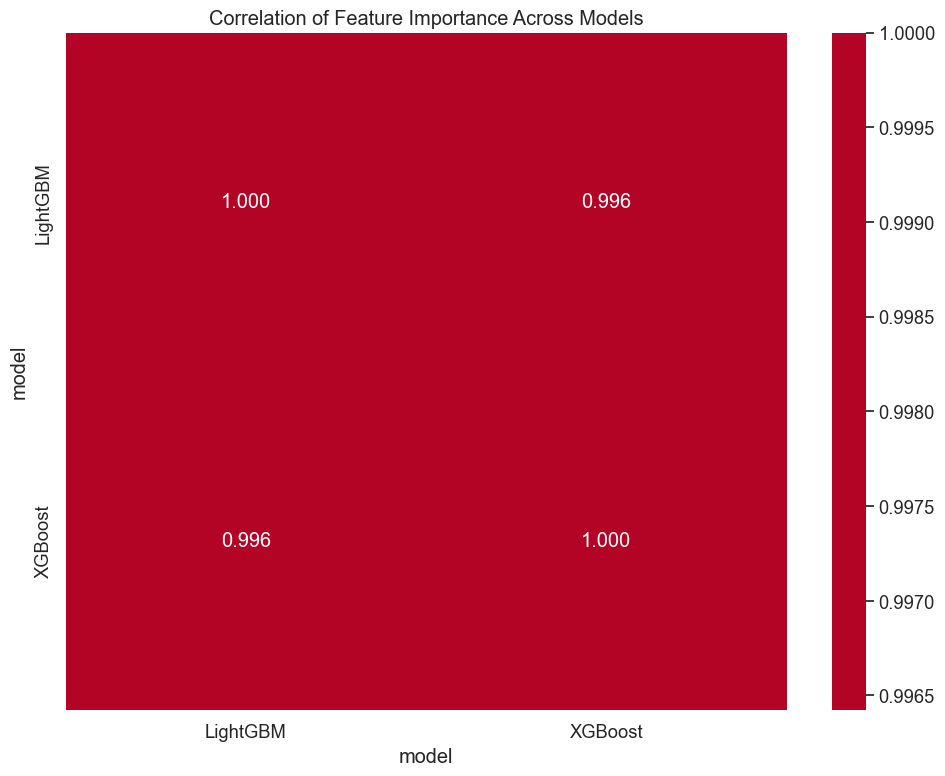

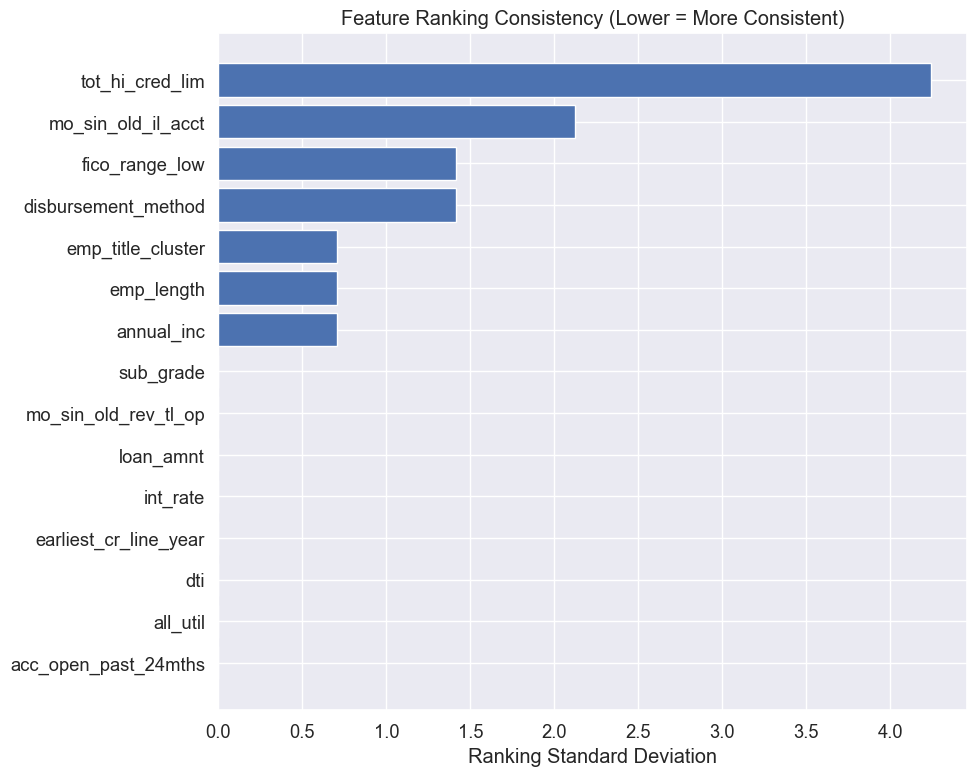


Combined SHAP importance saved to 'results/combined_shap_importance.csv'


In [56]:
# Install SHAP if not already installed
%pip install shap

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Initialize SHAP JavaScript support
shap.initjs()

def explain_model_with_shap(model_name, model_pipeline, X_test_subset, y_test, feature_names):
    """
    Explain model predictions using SHAP, with each plot displayed separately
    """
    print(f"\n{'='*50}")
    print(f"SHAP Analysis for {model_name}")
    print(f"{'='*50}")
    
    # Extract trained model and transformed data from pipeline
    if hasattr(model_pipeline, 'named_steps'):
        trained_model = model_pipeline.named_steps['model']
        X_transformed = model_pipeline[:-1].transform(X_test_subset)
    else:
        trained_model = model_pipeline
        X_transformed = X_test_subset[feature_names]
    
    # Create SHAP explainer based on model type
    if 'RandomForest' in model_name or 'XGBoost' in model_name or 'LightGBM' in model_name:
        explainer = shap.TreeExplainer(trained_model)
        shap_values = explainer.shap_values(X_transformed)
        
        # For binary classification, focus on class 1
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
    else:
        # For other models (Linear, ANN, etc.)
        sample_size = min(100, len(X_transformed))
        X_sample = X_transformed[:sample_size]
        
        explainer = shap.Explainer(trained_model.predict_proba, X_sample)
        shap_values = explainer(X_transformed[:sample_size])
        
        # For binary classification, extract class 1 values
        if hasattr(shap_values, 'values') and len(shap_values.values.shape) == 3:
            shap_values = shap_values.values[:, :, 1]
        elif hasattr(shap_values, 'values'):
            shap_values = shap_values.values
    
    # --------------------------
    # 1. Summary Bar Plot
    # --------------------------
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values, 
        X_transformed, 
        feature_names=feature_names, 
        plot_type="bar", 
        show=False, 
        max_display=15
    )
    plt.title(f'{model_name}: Feature Importance (Mean |SHAP Value|)')
    plt.tight_layout()
    plt.savefig(f'results/plots/{model_name}_shap_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # --------------------------
    # 2. Summary Violin Plot
    # --------------------------
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values, 
        X_transformed, 
        feature_names=feature_names, 
        show=False, 
        max_display=15
    )
    plt.title(f'{model_name}: SHAP Value Distribution')
    plt.tight_layout()
    plt.savefig(f'results/plots/{model_name}_shap_violin.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # --------------------------
    # 3. Waterfall Plot (First Prediction)
    # --------------------------
    plt.figure(figsize=(10, 6))
    if hasattr(shap_values, 'base_values'):
        shap.waterfall_plot(shap_values[0], show=False)
    else:
        expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
        shap.waterfall_plot(
            shap.Explanation(
                values=shap_values[0], 
                base_values=expected_value, 
                data=X_transformed.iloc[0] if hasattr(X_transformed, 'iloc') else X_transformed[0],
                feature_names=feature_names
            ), 
            show=False
        )
    plt.title(f'{model_name}: Prediction Explanation (First Sample)')
    plt.tight_layout()
    plt.savefig(f'results/plots/{model_name}_shap_waterfall.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # --------------------------
    # 4. Feature Importance Ranking
    # --------------------------
    plt.figure(figsize=(10, 8))
    feature_importance = np.abs(shap_values).mean(0)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=True)

    top_features = importance_df.tail(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Mean |SHAP Value|')
    plt.title(f'{model_name}: Top 15 Important Features')
    plt.tight_layout()
    plt.savefig(f'results/plots/{model_name}_shap_ranking.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # --------------------------
    # 5. Partial Dependence Plot
    # --------------------------
    if len(feature_names) > 0:
        plt.figure(figsize=(10, 6))
        top_feature_idx = np.abs(shap_values).mean(0).argmax()
        top_feature = feature_names[top_feature_idx]
        
        shap.partial_dependence_plot(
            top_feature_idx,
            trained_model.predict_proba,
            X_transformed, 
            ice=False,
            model_expected_value=True,
            feature_expected_value=True,
            show=False
        )
        plt.title(f'{model_name}: Partial Dependence - {top_feature}')
        plt.tight_layout()
        plt.savefig(f'results/plots/{model_name}_shap_pdp.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    # --------------------------
    # 6. SHAP Value Distribution
    # --------------------------
    plt.figure(figsize=(10, 6))
    plt.hist(shap_values.flatten(), bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('SHAP Values')
    plt.ylabel('Frequency')
    plt.title(f'{model_name}: Distribution of SHAP Values')
    plt.tight_layout()
    plt.savefig(f'results/plots/{model_name}_shap_dist.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Save feature importance to CSV
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'mean_shap_importance': np.abs(shap_values).mean(0),
        'mean_shap_value': shap_values.mean(0)
    }).sort_values('mean_shap_importance', ascending=False)
    
    importance_df.to_csv(f'results/{model_name}_shap_feature_importance.csv', index=False)
    
    print(f"\nTop 10 Important Features for {model_name}:")
    print(importance_df.head(10).to_string(index=False))
    
    return shap_values, importance_df


def compare_shap_importance_across_models(shap_results):
    """Compare SHAP feature importance across models"""
    # Combine all importance data
    all_importance = []
    for model_name, (shap_values, importance_df) in shap_results.items():
        temp_df = importance_df.copy()
        temp_df['model'] = model_name
        all_importance.append(temp_df[['feature', 'mean_shap_importance', 'model']])
    
    combined_df = pd.concat(all_importance, ignore_index=True)
    
    # Get top 15 features across all models
    top_features = (combined_df.groupby('feature')['mean_shap_importance']
                   .mean().sort_values(ascending=False).head(15).index.tolist())
    plot_df = combined_df[combined_df['feature'].isin(top_features)]
    
    # --------------------------
    # 1. Importance Heatmap
    # --------------------------
    plt.figure(figsize=(12, 8))
    pivot_df = plot_df.pivot(index='feature', columns='model', values='mean_shap_importance').fillna(0)
    sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Mean |SHAP Value|'})
    plt.title('SHAP Feature Importance Across Models')
    plt.ylabel('Features')
    plt.xlabel('Models')
    plt.tight_layout()
    plt.savefig('results/plots/shap_heatmap_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # --------------------------
    # 2. Bar Plot Comparison
    # --------------------------
    plt.figure(figsize=(12, 8))
    sns.barplot(data=plot_df, x='mean_shap_importance', y='feature', hue='model')
    plt.title('SHAP Feature Importance Comparison')
    plt.xlabel('Mean |SHAP Value|')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig('results/plots/shap_bar_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # --------------------------
    # 3. Correlation Heatmap
    # --------------------------
    if len(pivot_df.columns) > 1:
        plt.figure(figsize=(10, 8))
        corr_matrix = pivot_df.corr()
        sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0)
        plt.title('Correlation of Feature Importance Across Models')
        plt.tight_layout()
        plt.savefig('results/plots/shap_corr_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    # --------------------------
    # 4. Ranking Consistency
    # --------------------------
    plt.figure(figsize=(10, 8))
    model_rankings = {}
    for model in pivot_df.columns:
        model_rankings[model] = pivot_df[model].rank(ascending=False)
    
    ranking_df = pd.DataFrame(model_rankings)
    ranking_std = ranking_df.std(axis=1).sort_values()
    
    plt.barh(range(len(ranking_std.head(15))), ranking_std.head(15).values)
    plt.yticks(range(len(ranking_std.head(15))), ranking_std.head(15).index)
    plt.xlabel('Ranking Standard Deviation')
    plt.title('Feature Ranking Consistency (Lower = More Consistent)')
    plt.tight_layout()
    plt.savefig('results/plots/shap_ranking_consistency.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    return combined_df


# --------------------------
# Execute SHAP Analysis
# --------------------------
print("Starting SHAP Analysis for all models...")

# Prepare test data subset for faster computation
test_sample_size = min(500, len(X_test))
X_test_sample = X_test.head(test_sample_size)
y_test_sample = y_test.head(test_sample_size)

shap_results = {}

# 1. XGBoost Analysis
print("\nAnalyzing XGBoost...")
try:
    import xgboost as xgb
    
    xgb_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('model', xgb.XGBClassifier(
            n_estimators=500, 
            max_depth=6, 
            learning_rate=0.1,
            scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
            random_state=42, 
            eval_metric='auc'
        ))
    ])
    xgb_pipeline.fit(X_train, y_train)
    shap_values_xgb, importance_xgb = explain_model_with_shap(
        "XGBoost", xgb_pipeline, X_test_sample, y_test_sample, feature_subset
    )
    shap_results['XGBoost'] = (shap_values_xgb, importance_xgb)
except Exception as e:
    print(f"Error in XGBoost SHAP analysis: {e}")

# 2. LightGBM Analysis
print("\nAnalyzing LightGBM...")
try:
    import lightgbm as lgb
    lgb_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('model', lgb.LGBMClassifier(
            n_estimators=500, 
            max_depth=6, 
            learning_rate=0.1,
            class_weight='balanced', 
            random_state=42
        ))
    ])
    lgb_pipeline.fit(X_train, y_train)
    shap_values_lgb, importance_lgb = explain_model_with_shap(
        "LightGBM", lgb_pipeline, X_test_sample, y_test_sample, feature_subset
    )
    shap_results['LightGBM'] = (shap_values_lgb, importance_lgb)
except Exception as e:
    print(f"Error in LightGBM SHAP analysis: {e}")

# 3. Logistic Regression Analysis
print("\nAnalyzing Logistic Regression...")
try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    
    lr_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(
            class_weight='balanced', 
            random_state=42, 
            max_iter=1000
        ))
    ])
    lr_pipeline.fit(X_train, y_train)
    shap_values_lr, importance_lr = explain_model_with_shap(
        "LogisticRegression", lr_pipeline, X_test_sample, y_test_sample, feature_subset
    )
    shap_results['LogisticRegression'] = (shap_values_lr, importance_lr)
except Exception as e:
    print(f"Error in Logistic Regression SHAP analysis: {e}")

print(f"\nSHAP analysis completed for {len(shap_results)} models.")

# Cross-model comparison
if len(shap_results) > 1:
    print("\nComparing SHAP importance across models...")
    combined_importance = compare_shap_importance_across_models(shap_results)
    combined_importance.to_csv('results/combined_shap_importance.csv', index=False)
    print("\nCombined SHAP importance saved to 'results/combined_shap_importance.csv'")

Starting SHAP Analysis for all models...

Analyzing XGBoost...

SHAP Analysis for XGBoost

SHAP Analysis for XGBoost


<Figure size 2000x1500 with 0 Axes>

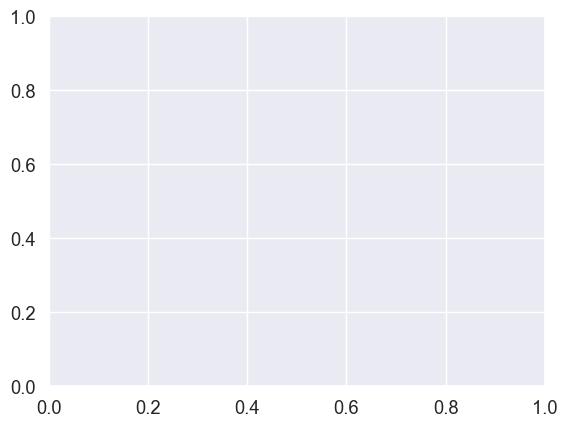

<Figure size 2000x1500 with 0 Axes>

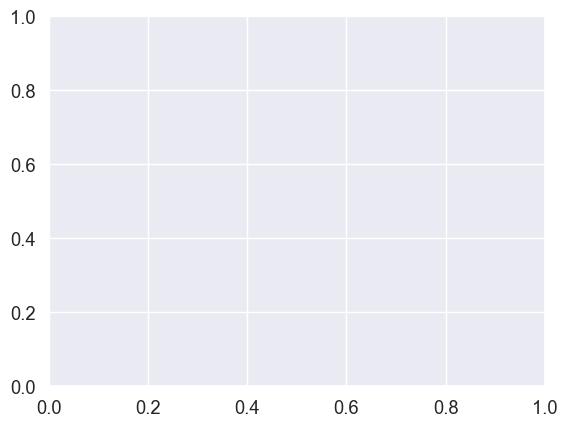

<Figure size 2000x1500 with 0 Axes>

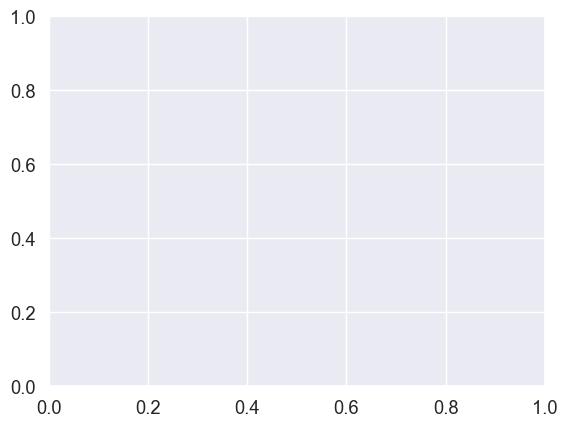

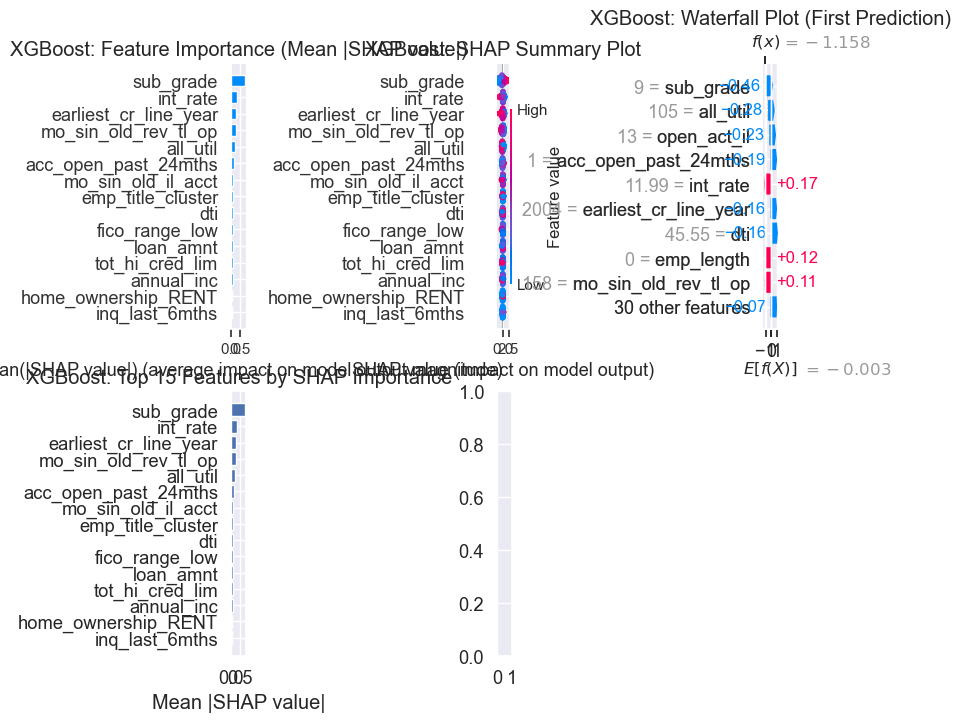

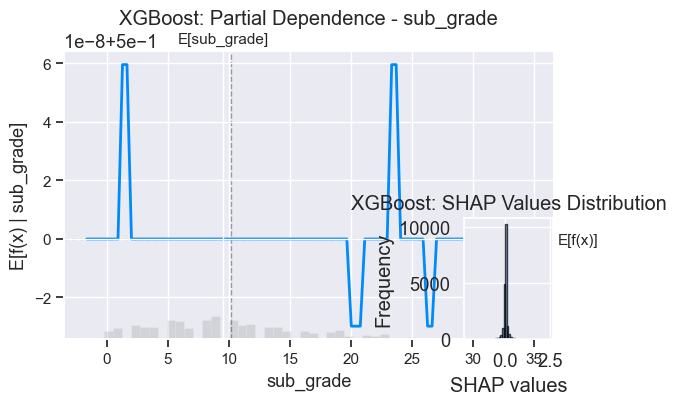


Top 10 Most Important Features for XGBoost:
              feature  mean_shap_importance  mean_shap_value
            sub_grade              0.776517        -0.265412
             int_rate              0.314720         0.018546
earliest_cr_line_year              0.272642         0.007781
 mo_sin_old_rev_tl_op              0.232092        -0.056629
             all_util              0.207473        -0.029789
 acc_open_past_24mths              0.118491        -0.024782
   mo_sin_old_il_acct              0.098425        -0.025413
    emp_title_cluster              0.079559         0.024052
                  dti              0.078969        -0.012097
       fico_range_low              0.068462        -0.008905

Analyzing LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 203438, number of negative: 1378498
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021192 seconds.
You

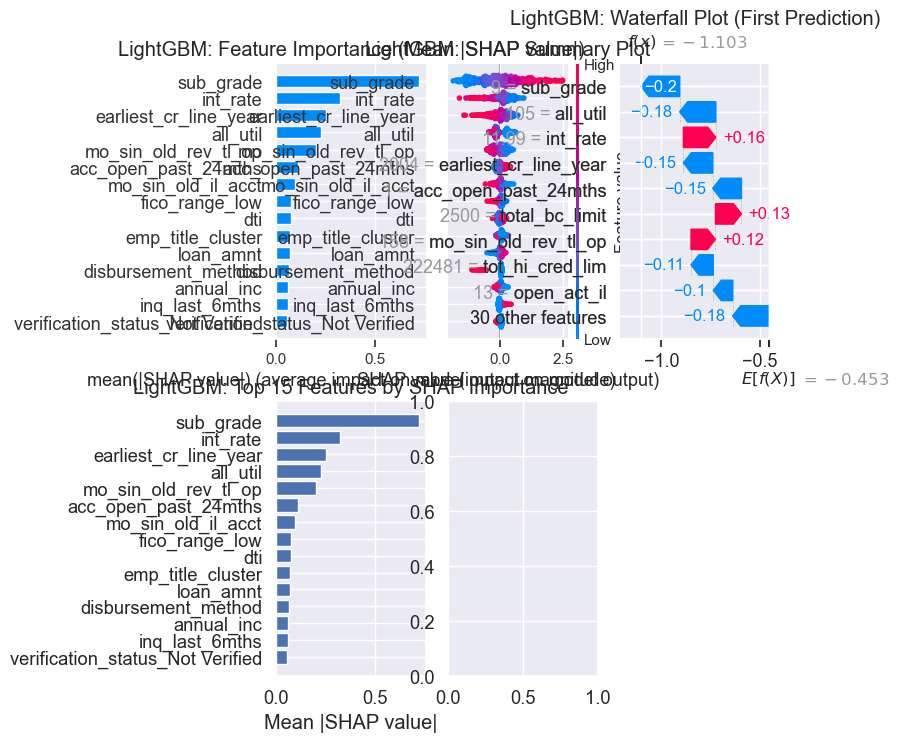

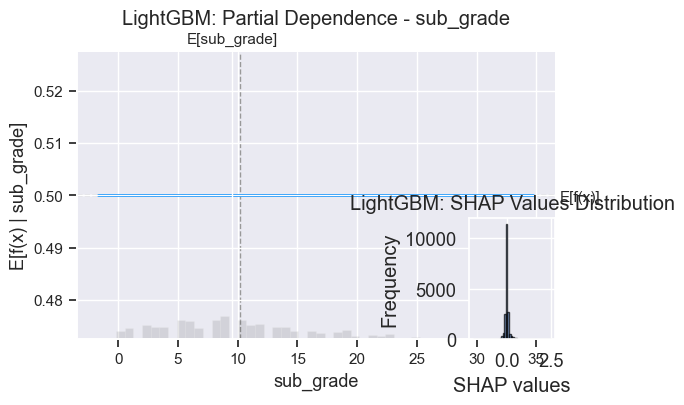


Top 10 Most Important Features for LightGBM:
              feature  mean_shap_importance  mean_shap_value
            sub_grade              0.723192        -0.069485
             int_rate              0.324431         0.044764
earliest_cr_line_year              0.255745         0.011687
             all_util              0.229047         0.006244
 mo_sin_old_rev_tl_op              0.205549        -0.021442
 acc_open_past_24mths              0.113436        -0.014050
   mo_sin_old_il_acct              0.098017        -0.009206
       fico_range_low              0.078127         0.007843
                  dti              0.077369         0.002308
    emp_title_cluster              0.075033         0.032815

Analyzing Logistic Regression...

SHAP Analysis for LogisticRegression

SHAP Analysis for LogisticRegression
Error in Logistic Regression SHAP analysis: Feature and SHAP matrices must have the same number of rows!

SHAP analysis completed for 2 models.

Comparing SHAP importance ac

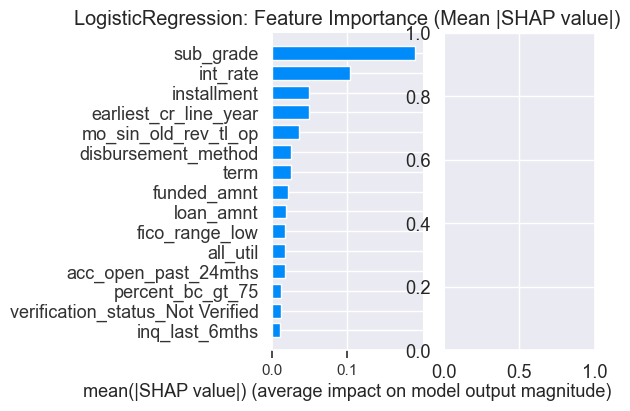

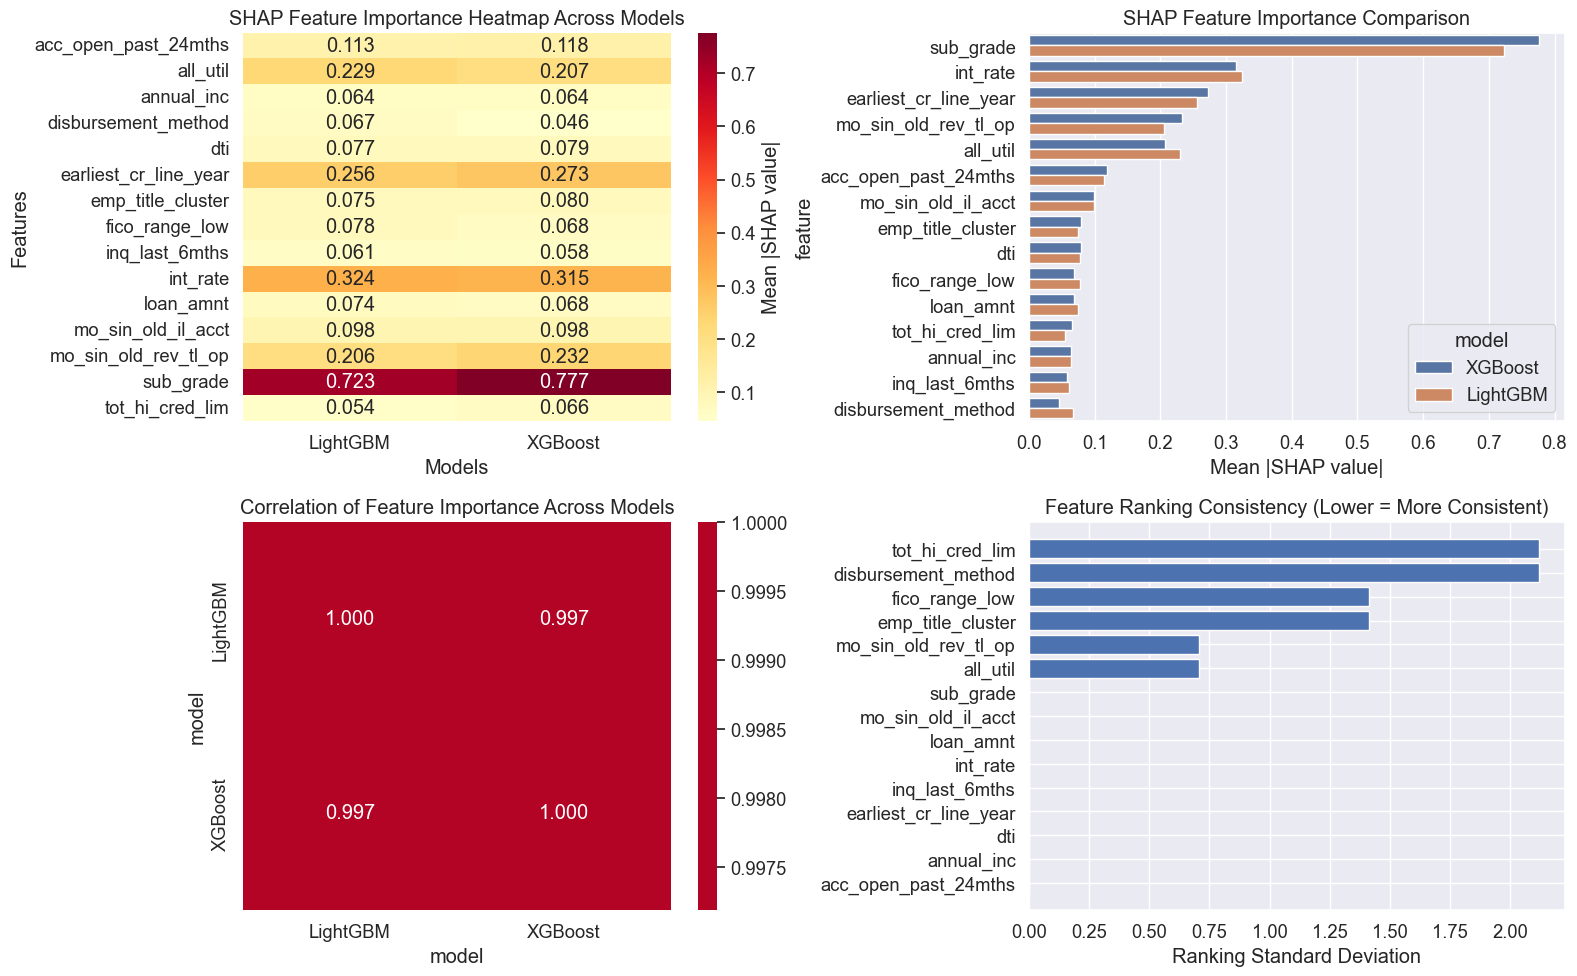


Combined SHAP importance saved to 'results/combined_shap_importance.csv'


In [38]:
# Run SHAP analysis for all trained models
print("Starting SHAP Analysis for all models...")

# Prepare test data subset for faster computation
test_sample_size = min(500, len(X_test))  # Use subset for faster computation
X_test_sample = X_test.head(test_sample_size)
y_test_sample = y_test.head(test_sample_size)

# Store SHAP results
shap_results = {}

# Load trained models (assuming they're stored in all_results)
model_pipelines = {}

# For demonstration, let's retrain a simple version of each model for SHAP analysis
# In practice, you would load your saved models

# 2. XGBoost
print("\nAnalyzing XGBoost...")
try:
    xgb_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('model', xgb.XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.1,
                                  scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
                                  random_state=42, eval_metric='auc'))
    ])
    xgb_pipeline.fit(X_train, y_train)
    shap_values_xgb, importance_xgb = explain_model_with_shap(
        "XGBoost", xgb_pipeline, X_test_sample, y_test_sample, feature_subset
    )
    shap_results['XGBoost'] = (shap_values_xgb, importance_xgb)
except Exception as e:
    print(f"Error in XGBoost SHAP analysis: {e}")

# 3. LightGBM
print("\nAnalyzing LightGBM...")
try:
    lgb_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('model', lgb.LGBMClassifier(n_estimators=500, max_depth=6, learning_rate=0.1,
                                   class_weight='balanced', random_state=42))
    ])
    lgb_pipeline.fit(X_train, y_train)
    shap_values_lgb, importance_lgb = explain_model_with_shap(
        "LightGBM", lgb_pipeline, X_test_sample, y_test_sample, feature_subset
    )
    shap_results['LightGBM'] = (shap_values_lgb, importance_lgb)
except Exception as e:
    print(f"Error in LightGBM SHAP analysis: {e}")

# 4. Logistic Regression
print("\nAnalyzing Logistic Regression...")
try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    
    lr_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
    ])
    lr_pipeline.fit(X_train, y_train)
    shap_values_lr, importance_lr = explain_model_with_shap(
        "LogisticRegression", lr_pipeline, X_test_sample, y_test_sample, feature_subset
    )
    shap_results['LogisticRegression'] = (shap_values_lr, importance_lr)
except Exception as e:
    print(f"Error in Logistic Regression SHAP analysis: {e}")

print(f"\nSHAP analysis completed for {len(shap_results)} models.")

# Compare SHAP importance across models
if len(shap_results) > 1:
    print("\nComparing SHAP importance across models...")
    combined_importance = compare_shap_importance_across_models(shap_results)
    
    # Save combined results
    combined_importance.to_csv('results/combined_shap_importance.csv', index=False)
    print("\nCombined SHAP importance saved to 'results/combined_shap_importance.csv'")

In [ ]:
# Advanced SHAP Analysis and Individual Prediction Explanations

def analyze_individual_predictions(model_name, model_pipeline, X_sample, y_sample, feature_names, n_examples=5):
    """
    Analyze individual predictions with SHAP explanations
    """
    print(f"\n{'='*60}")
    print(f"Individual Prediction Analysis for {model_name}")
    print(f"{'='*60}")
    
    # Get model predictions
    y_pred = model_pipeline.predict(X_sample)
    y_pred_proba = model_pipeline.predict_proba(X_sample)[:, 1]
    
    # Extract the trained model from pipeline
    if hasattr(model_pipeline, 'named_steps'):
        trained_model = model_pipeline.named_steps['model']
        X_transformed = model_pipeline[:-1].transform(X_sample)
    else:
        trained_model = model_pipeline
        X_transformed = X_sample[feature_names]
    
    # Create SHAP explainer
    if 'RandomForest' in model_name or 'XGBoost' in model_name or 'LightGBM' in model_name:
        explainer = shap.TreeExplainer(trained_model)
        shap_values = explainer.shap_values(X_transformed)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # For binary classification, use class 1
    else:
        # For other models, use a smaller sample for the explainer
        explainer = shap.Explainer(trained_model.predict_proba, X_transformed[:50])
        shap_explanation = explainer(X_transformed[:n_examples])
        if hasattr(shap_explanation, 'values') and len(shap_explanation.values.shape) == 3:
            shap_values = shap_explanation.values[:, :, 1]
        else:
            shap_values = shap_explanation.values
    
    # Analyze specific examples
    examples_to_analyze = [
        ('High Risk Prediction', np.argsort(y_pred_proba)[-n_examples:]),
        ('Low Risk Prediction', np.argsort(y_pred_proba)[:n_examples]),
    ]
    
    for category, indices in examples_to_analyze:
        print(f"\n{category} Examples:")
        print("-" * 40)
        
        for i, idx in enumerate(indices):
            actual = y_sample.iloc[idx] if hasattr(y_sample, 'iloc') else y_sample[idx]
            predicted = y_pred[idx]
            probability = y_pred_proba[idx]
            
            print(f"\nExample {i+1} (Index {idx}):")
            print(f"  Actual: {'Default' if actual == 1 else 'Non-Default'}")
            print(f"  Predicted: {'Default' if predicted == 1 else 'Non-Default'}")
            print(f"  Default Probability: {probability:.4f}")
            
            # Show top contributing features
            if len(shap_values.shape) == 2:
                feature_contributions = list(zip(feature_names, shap_values[idx]))
            else:
                feature_contributions = list(zip(feature_names, shap_values[idx] if idx < len(shap_values) else shap_values[0]))
            
            # Sort by absolute contribution
            feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
            
            print("  Top 5 Contributing Features:")
            for feat_name, contribution in feature_contributions[:5]:
                direction = "increases" if contribution > 0 else "decreases"
                print(f"    {feat_name}: {contribution:.4f} ({direction} default risk)")

def create_shap_dashboard(shap_results, feature_subset):
    """
    Create a comprehensive SHAP dashboard
    """
    print("\n" + "="*60)
    print("CREATING SHAP INTERPRETABILITY DASHBOARD")
    print("="*60)
    
    # 1. Feature Importance Consistency Analysis
    plt.figure(figsize=(20, 12))
    
    # Collect all importance data
    importance_data = []
    for model_name, (shap_values, importance_df) in shap_results.items():
        for _, row in importance_df.head(20).iterrows():  # Top 20 features
            importance_data.append({
                'model': model_name,
                'feature': row['feature'],
                'importance': row['mean_shap_importance'],
                'shap_value': row['mean_shap_value']
            })
    
    importance_df_all = pd.DataFrame(importance_data)
    
    # Top features across all models
    top_features = (importance_df_all.groupby('feature')['importance']
                   .mean().sort_values(ascending=False).head(15).index.tolist())
    
    # 1. Feature importance heatmap
    plt.subplot(3, 3, 1)
    pivot_importance = importance_df_all[importance_df_all['feature'].isin(top_features)].pivot(
        index='feature', columns='model', values='importance'
    ).fillna(0)
    sns.heatmap(pivot_importance, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title('Feature Importance Across Models')
    plt.ylabel('Features')
    
    # 2. Feature importance distribution
    plt.subplot(3, 3, 2)
    for model_name in importance_df_all['model'].unique():
        model_data = importance_df_all[importance_df_all['model'] == model_name]
        plt.hist(model_data['importance'], alpha=0.6, label=model_name, bins=20)
    plt.xlabel('SHAP Importance')
    plt.ylabel('Frequency')
    plt.title('Distribution of Feature Importance')
    plt.legend()
    
    # 3. Top 10 most consistent features
    plt.subplot(3, 3, 3)
    feature_std = pivot_importance.std(axis=1).sort_values()
    top_consistent = feature_std.head(10)
    plt.barh(range(len(top_consistent)), top_consistent.values)
    plt.yticks(range(len(top_consistent)), top_consistent.index)
    plt.xlabel('Std Dev of Importance')
    plt.title('Most Consistent Features (Low Std)')
    
    # 4. SHAP value distribution by model
    plt.subplot(3, 3, 4)
    shap_value_data = []
    for model_name, (shap_values, _) in shap_results.items():
        shap_value_data.extend([
            {'model': model_name, 'shap_value': val} 
            for val in shap_values.flatten()[:1000]  # Sample for speed
        ])
    
    shap_df = pd.DataFrame(shap_value_data)
    sns.boxplot(data=shap_df, x='model', y='shap_value')
    plt.xticks(rotation=45)
    plt.title('SHAP Value Distribution by Model')
    
    # 5. Feature correlation with target
    plt.subplot(3, 3, 5)
    avg_shap_by_feature = importance_df_all.groupby('feature')['shap_value'].mean().sort_values()
    top_positive = avg_shap_by_feature.tail(8)
    top_negative = avg_shap_by_feature.head(7)
    
    combined_features = pd.concat([top_negative, top_positive])
    colors = ['red' if x < 0 else 'green' for x in combined_features.values]
    
    plt.barh(range(len(combined_features)), combined_features.values, color=colors)
    plt.yticks(range(len(combined_features)), combined_features.index)
    plt.xlabel('Average SHAP Value')
    plt.title('Features with Highest Impact on Default Risk')
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    
    # 6. Model agreement on top features
    plt.subplot(3, 3, 6)
    top_10_features = importance_df_all.groupby('feature')['importance'].mean().nlargest(10).index
    agreement_scores = []
    
    for feature in top_10_features:
        feature_ranks = []
        for model_name, (_, importance_df) in shap_results.items():
            try:
                rank = importance_df.reset_index().index[importance_df['feature'] == feature].tolist()[0] + 1
                feature_ranks.append(rank)
            except:
                feature_ranks.append(len(importance_df))  # If feature not found, give lowest rank
        
        agreement_scores.append({
            'feature': feature,
            'rank_std': np.std(feature_ranks),
            'avg_rank': np.mean(feature_ranks)
        })
    
    agreement_df = pd.DataFrame(agreement_scores).sort_values('rank_std')
    plt.scatter(agreement_df['avg_rank'], agreement_df['rank_std'])
    for i, row in agreement_df.iterrows():
        plt.annotate(row['feature'][:15], (row['avg_rank'], row['rank_std']), 
                    fontsize=8, rotation=45)
    plt.xlabel('Average Rank')
    plt.ylabel('Rank Standard Deviation')
    plt.title('Feature Ranking Agreement Across Models')
    
    # 7. Feature importance vs model performance
    plt.subplot(3, 3, 7)
    if 'all_results' in globals():
        model_performance = []
        avg_importance = []
        
        for model_name, (_, importance_df) in shap_results.items():
            if model_name in all_results:
                model_performance.append(all_results[model_name]['test_roc_auc'])
                avg_importance.append(importance_df['mean_shap_importance'].mean())
        
        if model_performance and avg_importance:
            plt.scatter(avg_importance, model_performance)
            for i, model_name in enumerate(shap_results.keys()):
                if model_name in all_results:
                    plt.annotate(model_name, (avg_importance[i], model_performance[i]))
            plt.xlabel('Average Feature Importance')
            plt.ylabel('Test ROC-AUC')
            plt.title('Model Performance vs Feature Importance')
    
    # 8. SHAP value correlation between models
    plt.subplot(3, 3, 8)
    if len(shap_results) >= 2:
        model_names = list(shap_results.keys())
        model_correlations = []
        
        for i, model1 in enumerate(model_names):
            for j, model2 in enumerate(model_names):
                if i < j:  # Avoid duplicates
                    # Get common features
                    _, imp1 = shap_results[model1]
                    _, imp2 = shap_results[model2]
                    
                    common_features = set(imp1['feature']) & set(imp2['feature'])
                    if len(common_features) > 5:
                        imp1_common = imp1[imp1['feature'].isin(common_features)].sort_values('feature')
                        imp2_common = imp2[imp2['feature'].isin(common_features)].sort_values('feature')
                        
                        correlation = np.corrcoef(imp1_common['mean_shap_importance'], 
                                                 imp2_common['mean_shap_importance'])[0, 1]
                        model_correlations.append({
                            'model_pair': f'{model1}\nvs\n{model2}',
                            'correlation': correlation
                        })
        
        if model_correlations:
            corr_df = pd.DataFrame(model_correlations)
            plt.bar(range(len(corr_df)), corr_df['correlation'])
            plt.xticks(range(len(corr_df)), corr_df['model_pair'], rotation=45)
            plt.ylabel('Correlation Coefficient')
            plt.title('SHAP Importance Correlation Between Models')
            plt.ylim(0, 1)
    
    # 9. Summary statistics
    plt.subplot(3, 3, 9)
    plt.axis('off')
    
    # Create summary text
    summary_text = "SHAP Analysis Summary:\n\n"
    summary_text += f"Models Analyzed: {len(shap_results)}\n"
    summary_text += f"Features Analyzed: {len(feature_subset)}\n\n"
    
    # Most important features across all models
    if importance_data:
        top_5_global = importance_df_all.groupby('feature')['importance'].mean().nlargest(5)
        summary_text += "Top 5 Features (Global):\n"
        for i, (feature, importance) in enumerate(top_5_global.items(), 1):
            summary_text += f"{i}. {feature[:20]}\n"
    
    plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.savefig('results/plots/shap_comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return importance_df_all

# Run individual prediction analysis for available models
for model_name, model_pipeline_result in [
    ('RandomForest', rf_pipeline if 'rf_pipeline' in locals() else None),
    ('XGBoost', xgb_pipeline if 'xgb_pipeline' in locals() else None),
    ('LightGBM', lgb_pipeline if 'lgb_pipeline' in locals() else None),
]:
    if model_pipeline_result is not None:
        try:
            analyze_individual_predictions(
                model_name, model_pipeline_result, 
                X_test_sample, y_test_sample, feature_subset, n_examples=3
            )
        except Exception as e:
            print(f"Error in individual prediction analysis for {model_name}: {e}")

# Create comprehensive dashboard
if shap_results:
    dashboard_data = create_shap_dashboard(shap_results, feature_subset)
    
    # Save dashboard data
    dashboard_data.to_csv('results/shap_dashboard_data.csv', index=False)
    print("\nSHAP dashboard data saved to 'results/shap_dashboard_data.csv'")
    
    print("\n" + "="*60)
    print("SHAP INTERPRETABILITY ANALYSIS COMPLETE!")
    print("="*60)
    print("Generated files:")
    print("- Individual model SHAP plots: results/plots/*_shap_analysis.png")
    print("- Model comparison: results/plots/shap_model_comparison.png") 
    print("- Comprehensive dashboard: results/plots/shap_comprehensive_dashboard.png")
    print("- Feature importance CSVs: results/*_shap_feature_importance.csv")
    print("- Combined results: results/combined_shap_importance.csv")
    print("- Dashboard data: results/shap_dashboard_data.csv")
else:
    print("No SHAP results available. Please run the previous cell first.")